# 第5讲：打造专属Reader组件：轻松解析HTML、PDF等复杂文档格式
> 第一期教程我们介绍了 RAG 主要包括为检索、增强和生成等三个阶段，而在此之前还需要对文档读取与解析、预处理、索引构建和存储优化等操作。本期我们将深入到其中的文件读取部分，通过自定义读取组件来支持更多的数据格式。

由于 RAG 是从一个庞大的文档集合中检索相关信息，而文档的格式会是各种文件格式，所以需要 Reader （读取器）负责对检索阶段获取的相关文档进行恰当的处理，以保证后面可以生成高质量的回答响应。目前 LazyLLM 中的 Reader 默认支持的文档格式包括 pdf、doc、hwp、ppt、ipynb、epub、markdown、mbox、csv、excel、image、MP3、MP4。如果需要的文档格式不在 LazyLLM 的支持范围内或者 LazyLLM 支持的默认 Reader 输出的格式不符合自己的需求，则可以自己重新定义相应的 Reader 来使用。

本教程主要介绍 LazyLLM 如何使用自定义 Reader 组件的方法，读完本教程，您将学会 LazyLLM 使用自定义 Reader 的方法，并基于此 Reader 搭建一个简单的RAG应用。

## 环境准备

如果您的电脑上安装了Python，请通过下方命令安装lazyllm及必要的依赖包。关于 LazyLLM 的环境更详细的准备可以参考 [第2讲：10分钟上手一个最小可用RAG系统](../chapter2/2.ipynb) 中对应的内容。

In [ ]:
pip install lazyllm

## Reader 模块简介

### Reader 基本功能

前面已经讲过基础的 RAG 的流程了，这节我们主要了解一下 RAG 中的基础模块 Reader 的功能和使用。首先前面我们已经知道当 query 来了之后要先经过 Retriever 模块，然后输出检索到的相关文本片段。那么这里就有了一个问题，Retriever 模块检索到的这些文本片段是从哪里来的呢？这里就不得不提到我们将要介绍的 Reader 模块了。我们都知道 Retriever 是需要从知识库中检索和问题相关的信息，而知识库中的内容会是各种各样的，有结构化存储的，也有非结构化存储的。为了让 Retriever 中的检索模块和知识库中知识的存储格式解耦，就需要 Reader 模块来大显身手了。Reader 的功能就是负责把以各种形式存储的知识读取出来，然后以统一的格式给检索模块使用。

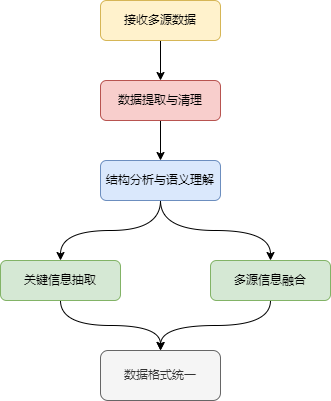

### Reader 使用方法

[完整GitHub代码链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter5/reader_use.py#L1)

接下来我们看看 Reader 的使用方法。首先，我们以 [cmrc2018](https://huggingface.co/datasets/LazyAGI/CMRC2018_Knowledge_Base/tree/main) 知识库中的 "part\_1.txt"为例，内容为:

```bash
MIT OpenCourseWare是由麻省理工学院在2002年创始的一项计划。它的目标是在2007年年底以前，让所有大学生和研究生课程能够在线上自由的被任何人从任何地点取用。MIT开放式课程也可以被视为一项庞大的、网路出版的MIT教材。这个计划由William and Flora Hewlett Foundation、Andrew W. Mellon Foundation、麻省理工学院共同主持。之后，这个计划更激励了不少机构将他们的教材转变为开放教育资源。2007年11月，已经有超过1800个课程在线上。其中少数仅是书单和讨论主题，大多数会提供课后问题、考试（通常附有解答）以及演讲笔记。某些课程甚至提供互动式的示范程式、MIT教授写的教科书、串流影音格式的演讲影片。2008年8月，1800个线上课程中，只有26个完整的演讲影片。并不是所有影片都附有演讲笔记，这导致了观看演讲时的困难。无论如何，那些完整的课程都具有良好的品质，而且许多演讲都非常地令人信服。线上的影片虽然都是影音串流，但也有可供下载后离线观看的方法。像是iTunes U就有提供这些影音档的下载。
参加2008年北京夏季奥林匹克运动会的中国皮划艇队共计40人，其中运动员23人，官员与工作人员17人，领队刘刚。皮划艇静水项目组共计28人，其中运动员18人；副领队宋广礼副领队：宋广礼教练员（7人）：孙尔杰、马克、钟成海、李戴源、何军、谭志宏、徐菊生医生：阙云太，管理：姜丹男运动员（12人）：刘海涛、李臻、林淼、周鹏、沈洁、潘耀、黄志鹏、孟关良、杨文军、陈忠云、张志武、李强女运动员（6人）：钟红燕、徐琳蓓、王 凤、于腊梅、许亚萍、梁培兴皮划艇激流回旋项目组共计11人，其中运动员5人；副领队：李欣教练员：张磊、马可武、克里斯帝安、汉斯、安吉利卡男运动员（4人）：胡明海、舒俊榕、冯黎明、丁富学女运动员（1人）：李晶晶男子单人划艇／冯黎明／预赛第1轮／第9位／成绩91.44（8月11日）；男子单人划艇／冯黎明／预赛第2轮／第12位／成绩90.55（8月11日）；男子单人划艇／冯黎明／预赛第1、2轮／第11位／总成绩181.99／落后小组第1位11.84（8月11日）；男子单人划艇／冯黎明／半决赛／第11位／总成绩94.64（92.64+罚时2）／落后小组第1位5.72（未入前8名被淘汰）（8月12日）男子单人皮艇／丁富学／预赛第1轮／成绩87.47／落后小组第1位5.68（8月11日）；男子单人皮艇／丁富学／预赛第1轮／成绩90.92／落后小组第1位5.68（8月11日）；男子单人皮艇／丁富学／预赛第1、2轮／第21位／总成绩228.39／落后小组第1位61.90（被淘汰）（8月11日）。
乍都节公园（）位于泰国的首都曼谷的乍都节县，是拍凤裕庭路、威拍哇丽兰室路、甘烹碧路之间的一处公众游园地。1975年由泰国国家铁路局捐献土地建筑成公园。1980年12月4日，泰国国王拉玛九世62岁生日那天，公园开放。它的面积约为0.304平方公里。后期，再在邻近地段，增辟「诗丽吉皇后公园」（Queen Sirikit Park）及「火车公园」（Rot Fai Park），都被「甘烹碧三街」所分隔。整个细长的公园被一个人工湖泊占据，许多桥梁跨越湖泊连接两岸。公园里亦有一座小型的火车博物馆，展示泰国的机车及车厢。每逢星期日，都会成为杂货市集，吸引许多观光客来购物。
摩尔甘比足球俱乐部（）是位于英格兰西北兰开夏郡渡假小镇莫克姆（Morecambe）的足球俱乐部。于2007年透过附加赛在球队历史内首次升级到英格兰足球联赛，现时在英格兰乙级联赛中作赛。"参见2015年至2016年英格兰足球乙级联赛"地球体育场（Globe Arena）位于英格兰兰开夏郡莫克姆（Morecambe）的足球场，取代自1921年已开始使用的基士堤公园球场（Christie Park），成为摩甘比的主场球场，以建造球场的「地球建筑公司」（Globe Construction）命名。2009年5月9日接收地盘进行平整工地，于同年9月初动工兴建上盖，由于工程延误，揭幕日期推迟一个球季至2010/11年球季才正式启用，于2010年8月10日英格兰联赛杯第一圈对-{zh-hans:考文垂; zh-hk:高云地利;}-进行首场赛事，摩甘比旗开得胜以2-0淘汰较高级别的对手，新加盟的安德鲁·弗莱明（Andrew "Andy" Fleming）包办两个入球。地球体育场可以容纳6,476名观众，其中在草坪长边的主看台有2,173个坐席，对面是可容606名观众没有顶盖的阶梯看台，龙门后方是主场及作客球迷看台，西看台可容2,234名主场球迷，而东看台则可让1,389名作客球迷进场观战。
达曼（）位于沙特阿拉伯的东部省，是沙特石油工业的重要中心。达曼是东部省最大的城市，达曼港也是波斯湾最大的海港之一。它的货物进出口量仅次于沙特位于红海海岸的吉达港。达曼拥有新建的法赫德国王国际机场，机场位于市西20km，有一条6车道公路连接。达曼的卫星城有现代经济中心 Khobar、世界最大的沙特Aramco石油公司所在地札哈兰以及渔业农业中心Qatif。几座城市（达曼、寇巴Khobar和札哈兰）共有200万人口，其中750,000居住在主城达曼。本地的体育场所是Mohamed bin法赫德王子体育场。达曼是沙特大陆桥计划的东段终点，西端终点在吉达港。ISG-达曼
潘仕成（），字德畬、德舆，祖籍福建，家族世居广州，先祖以盐商起家，至潘仕成时为广州十三行家族巨贾第三代，晚清巨富、慈善家。清嘉庆九年(1804年)，祖籍福建且家族世居广州的潘仕成出生。潘仕成的先祖以盐商起家，至潘仕成时为第三代经营，成为广州十三行巨贾，与米利坚商人颇多熟悉，亦素为该国夷人所敬重。曾捐官20万两白银使自己成为二品官，亦曾镇压广东连山瑶族有功。鸦片战争爆发时，又捐助军需银八万两，得赏戴花翎，封为道员头衔。清道光年间，官至兵部侍郎。道光二十二年（1842年）十月，潘自行出资延请美国军官壬雷斯在广州研发水雷。道光二十三年（1843年）七月，由李光铨等将制成的水雷送北京，在天津试演。又从国外引进牛痘，被誉为“轻财好义，地方善举资助弗吝”。晚年横遭变故，经济拮据。清同治十年(1871年)，将《佩文韵府》的木刻版抵押给山西票号。清同治十二年(1873年)，卒。
马飚（），壮族，广西田阳人；中央民族学院政治系毕业。1985年6月加入中国共产党，是中共第十七届中央候补委员，十八、十九届中央委员。曾任广西壮族自治区人民政府主席。现任第十二届全国政协副主席。文化大革命期间，马飚中学毕业后，在广西柳州钢铁厂当工人。高考制度恢复后，于1978年考入中央民族学院政治系政治经济学专业学习。毕业后，从事经济研究工作，先后在广西壮族自治区计划委员会计划经济研究所和中国社会科学院民族研究所任职；期间，还曾在广西罗城县挂职担任县委副书记。1994年，马飚出任中共北海市委书记助理，步入政界。此后，历任广西壮族自治区经济体制改革委员会副主任、自治区青年联合会副主席，百色地区行政公署专员，中共百色地委书记。2003年地市合并后，出任首任中共百色市委书记（省辖市）；2004年，升任自治区政府副主席；2005年3月起，任自治区党委常委、兼中共南宁市委书记、市人大常委会主任；2007年12月，任自治区党委副书记，政府副主席、代主席；2008年1月，正式当选广西壮族自治区人民政府主席。2013年3月，作为壮族代表，接替李兆焯，当选为第十二届全国政协副主席。
<br>西班牙语言（lenguas de España）指的在西班牙使用或曾经使用的语言。罗曼语族的语言在西班牙被广泛使用，其中只有西班牙语（español）（或称为卡斯蒂利亚语（castellano））拥有全国官方语言的地位，有些语言只在某些地区是官方语言，同时也有一些非官方的语言或方言。在西班牙，有最多使用者及最具优势的语言是西班牙语，基本上每个西班牙人都以西班牙语为母语或第二语言。在2005年，89%的西班牙人的母语是西班牙语，9%是加泰罗尼亚语，而加利西亚语和巴斯克语则分别有5%和1%的母语使用者。由于有3%人口可以说两种母语，所以以上的比率加起来超过100%。一些语言在某地区有较多的使用者：上述语言都是地方性的官方语言，除了Aranese之外，其余3种语言都在各自的地区广泛使用，并有报刊、书籍等媒体使用该种语言，而加泰罗尼亚语及加利西亚语更被地区政府用作行政语言。西班牙境内还有一些语言只有少数人使用：西班牙语本身也有不同的方言，例如Andalusian及Canarian方言，每种方言之下又有各自的变体。在加利西亚，加利西亚语和葡萄牙语的关系曾引起过争议，有语言学家认为虽然这两种语言的音系和词汇不一样，但它们是同一种语言的方言（见）。相反意见认为，正是由于这两种语言的音系和词汇不一样，它们是两种不同的语言。历史上曾在现今西班牙境内使用的语言包括：不在西班牙使用但与西班牙有联系的语言包括：
南田县是浙江省一个已经撤消的县，存县期间，范围包括今宁波市象山县的南田岛、高塘岛、花岙岛、檀头山、坦塘岛、渔山列岛等。道光三年（1824年），宁波府海防同知移驻象山县石浦（亦有称石浦厅）。光绪初年，南田岛置开垦委员，宣统元年六月癸卯（1909年8月11日）于大佛头山麓改置为南田厅，设抚民通判，同年驻地移樊岙。民国元年（1912年）2月，南田厅改置为南田县，县政府驻樊岙。4月，原石浦厅（废厅后并回象山县），即象山县东溪岭以南地划入南田县，县府迁治石浦。民国二年（1913年）石浦等地复归象山县，南田县还驻樊岙。民国29年（1940年）7月1日，南田县撤消，合宁海县、临海县部分地区合置三门县，县府移至今六敖健康塘。1952年原南田县所属区域从三门县划出，重新划归象山县，仅满山（岛屿）仍划归三门县，并成为三门县、象山县和宁海县的海上界岛。
有田中井手之战是武田元繁与毛利元就的战争，也是毛利元就的初阵，最后武田元繁战死，被誉为西国的桶狭间之战。毛利元就1000人，武田元繁5000人。当时正值毛利家当主毛利兴元方才去世不久，年仅两岁的其子毛利幸松丸被拥立为下任当主，由当时尚无作战经验的元就与其弟相合元纲共同担任监护人之职，坐镇于佐东银山城的武田元繁见有机可趁，随即命令部下熊谷元直担任先锋，率军前往毛利领地烧杀掳掠，自己则会同香川行景、己斐宗瑞等豪族，进攻位于吉田郡山城邻近的有田城。隶属于吉川家的有田城主小田信忠，闻知武田家大军来袭，随即派出使者前往毛利家求援。毛利元就以有田城若失陷，则吉田郡山城亦将不保的考量下，决定率领部队支援。首先击杀了武田家的先锋熊谷元直，武田元繁闻元直死讯而大怒，亲率部队来迎战元就。时值夜色，元就采奇袭战术，使武田军势大乱，武田元繁在混乱中遇袭身亡，决定了毛利家的胜利。有田中井手之战 - 吉田郡山城之战 - 第一次月山富田城之战 - 折敷畑之战 - 严岛之战 - 防长经略 - 忍原崩 - 第二次月山富田城之战 - 多多良滨之战 - 布部山之战 - 上月城之战 - 备中兵乱 - 鸟取城之战 - 备中高松城之战%
```

我们先导入需要用到的包，因为 Reader 模块是在 Document 内部使用的，所以这里我们先导入 Document 模块。

In [ ]:
from lazyllm.tools.rag import Document

然后我们基于上面的文档创建一个 Document 实例。

In [ ]:
doc = Document(dataset_path="your_doc_path")

然后我们直接通过 Document 实例来调用 Reader 的模块，并传入上面的文档路径。

In [ ]:
data = doc._impl._reader.load_data(input_files=["your_doc_path/part_1.txt"])

由于 Reader 模块是通过 load\_data 来加载数据的，所以上面这里需要调用 load\_data 接口。

> 这里需要注意一下，input\_files 中的文件列表必须要传入文件的相对路径或者绝对路径。因为正常情况下这个 ​*​*`load_data`*​*接口是 Document 类内部调用的，用户是看不到的，所以代码中会利用实例化 Document 时传入的 ​*​*`dataset_path`*​*​ 以及环境变量中配置的 ​*​* `LAZYLLM_DATA_PATH` *​*​ 环境变量拼接出知识库的路径，然后遍历知识库中的所有文档的。

下面我们看看 Reader 模块加载完这个文档之后，输出的是什么内容？通过下面的命令，我们打印一下 Reader 模块的输出：

In [ ]:
print(f"data: {data}")

输出的结果是：
```bash
data: [<Node id=23b37172-1c5d-45d4-a9e1-d70fee799116>]
```

可以看到 Reader 模块输出的内容是一个 list 类型，然后里面的元素是 Node 类型，当然每次执行，这里的id会不同，这是正常的，因为这里的 id 是唯一的，不会出现重复。这里的 Node 类型是什么类型呢？一般 Node 类型里面会存放相应的文本信息、embedding信息、元数据、以及 Node 之间的关系等等。这里只要知道 Node 类型就是把 Reader 解析出来的内容进行封装，方便后面检索模块统一处理即可。

既然 Node 类型是把 Reader 解析出来的内容进行了封装，那我们就进一步看看 Node 里面的文本信息是什么：

In [ ]:
print(f"text: {data[0].text}")

输出的结果是：

```bash
data: MIT OpenCourseWare是由麻省理工学院在2002年创始的一项计划。它的目标是在2007年年底以前，让所有大学生和研究生课程能够在线上自由的被任何人从任何地点取用。MIT开放式课程也可以被视为一项庞大的、网路出版的MIT教材。这个计划由William and Flora Hewlett Foundation、Andrew W. Mellon Foundation、麻省理工学院共同主持。之后，这个计划更激励了不少机构将他们的教材转变为开放教育资源。2007年11月，已经有超过1800个课程在线上。其中少数仅是书单和讨论主题，大多数会提供课后问题、考试（通常附有解答）以及演讲笔记。某些课程甚至提供互动式的示范程式、MIT教授写的教科书、串流影音格式的演讲影片。2008年8月，1800个线上课程中，只有26个完整的演讲影片。并不是所有影片都附有演讲笔记，这导致了观看演讲时的困难。无论如何，那些完整的课程都具有良好的品质，而且许多演讲都非常地令人信服。线上的影片虽然都是影音串流，但也有可供下载后离线观看的方法。像是iTunes U就有提供这些影音档的下载。
参加2008年北京夏季奥林匹克运动会的中国皮划艇队共计40人，其中运动员23人，官员与工作人员17人，领队刘刚。皮划艇静水项目组共计28人，其中运动员18人；副领队宋广礼副领队：宋广礼教练员（7人）：孙尔杰、马克、钟成海、李戴源、何军、谭志宏、徐菊生医生：阙云太，管理：姜丹男运动员（12人）：刘海涛、李臻、林淼、周鹏、沈洁、潘耀、黄志鹏、孟关良、杨文军、陈忠云、张志武、李强女运动员（6人）：钟红燕、徐琳蓓、王 凤、于腊梅、许亚萍、梁培兴皮划艇激流回旋项目组共计11人，其中运动员5人；副领队：李欣教练员：张磊、马可武、克里斯帝安、汉斯、安吉利卡男运动员（4人）：胡明海、舒俊榕、冯黎明、丁富学女运动员（1人）：李晶晶男子单人划艇／冯黎明／预赛第1轮／第9位／成绩91.44（8月11日）；男子单人划艇／冯黎明／预赛第2轮／第12位／成绩90.55（8月11日）；男子单人划艇／冯黎明／预赛第1、2轮／第11位／总成绩181.99／落后小组第1位11.84（8月11日）；男子单人划艇／冯黎明／半决赛／第11位／总成绩94.64（92.64+罚时2）／落后小组第1位5.72（未入前8名被淘汰）（8月12日）男子单人皮艇／丁富学／预赛第1轮／成绩87.47／落后小组第1位5.68（8月11日）；男子单人皮艇／丁富学／预赛第1轮／成绩90.92／落后小组第1位5.68（8月11日）；男子单人皮艇／丁富学／预赛第1、2轮／第21位／总成绩228.39／落后小组第1位61.90（被淘汰）（8月11日）。
乍都节公园（）位于泰国的首都曼谷的乍都节县，是拍凤裕庭路、威拍哇丽兰室路、甘烹碧路之间的一处公众游园地。1975年由泰国国家铁路局捐献土地建筑成公园。1980年12月4日，泰国国王拉玛九世62岁生日那天，公园开放。它的面积约为0.304平方公里。后期，再在邻近地段，增辟「诗丽吉皇后公园」（Queen Sirikit Park）及「火车公园」（Rot Fai Park），都被「甘烹碧三街」所分隔。整个细长的公园被一个人工湖泊占据，许多桥梁跨越湖泊连接两岸。公园里亦有一座小型的火车博物馆，展示泰国的机车及车厢。每逢星期日，都会成为杂货市集，吸引许多观光客来购物。
摩尔甘比足球俱乐部（）是位于英格兰西北兰开夏郡渡假小镇莫克姆（Morecambe）的足球俱乐部。于2007年透过附加赛在球队历史内首次升级到英格兰足球联赛，现时在英格兰乙级联赛中作赛。"参见2015年至2016年英格兰足球乙级联赛"地球体育场（Globe Arena）位于英格兰兰开夏郡莫克姆（Morecambe）的足球场，取代自1921年已开始使用的基士堤公园球场（Christie Park），成为摩甘比的主场球场，以建造球场的「地球建筑公司」（Globe Construction）命名。2009年5月9日接收地盘进行平整工地，于同年9月初动工兴建上盖，由于工程延误，揭幕日期推迟一个球季至2010/11年球季才正式启用，于2010年8月10日英格兰联赛杯第一圈对-{zh-hans:考文垂; zh-hk:高云地利;}-进行首场赛事，摩甘比旗开得胜以2-0淘汰较高级别的对手，新加盟的安德鲁·弗莱明（Andrew "Andy" Fleming）包办两个入球。地球体育场可以容纳6,476名观众，其中在草坪长边的主看台有2,173个坐席，对面是可容606名观众没有顶盖的阶梯看台，龙门后方是主场及作客球迷看台，西看台可容2,234名主场球迷，而东看台则可让1,389名作客球迷进场观战。
达曼（）位于沙特阿拉伯的东部省，是沙特石油工业的重要中心。达曼是东部省最大的城市，达曼港也是波斯湾最大的海港之一。它的货物进出口量仅次于沙特位于红海海岸的吉达港。达曼拥有新建的法赫德国王国际机场，机场位于市西20km，有一条6车道公路连接。达曼的卫星城有现代经济中心 Khobar、世界最大的沙特Aramco石油公司所在地札哈兰以及渔业农业中心Qatif。几座城市（达曼、寇巴Khobar和札哈兰）共有200万人口，其中750,000居住在主城达曼。本地的体育场所是Mohamed bin法赫德王子体育场。达曼是沙特大陆桥计划的东段终点，西端终点在吉达港。ISG-达曼
潘仕成（），字德畬、德舆，祖籍福建，家族世居广州，先祖以盐商起家，至潘仕成时为广州十三行家族巨贾第三代，晚清巨富、慈善家。清嘉庆九年(1804年)，祖籍福建且家族世居广州的潘仕成出生。潘仕成的先祖以盐商起家，至潘仕成时为第三代经营，成为广州十三行巨贾，与米利坚商人颇多熟悉，亦素为该国夷人所敬重。曾捐官20万两白银使自己成为二品官，亦曾镇压广东连山瑶族有功。鸦片战争爆发时，又捐助军需银八万两，得赏戴花翎，封为道员头衔。清道光年间，官至兵部侍郎。道光二十二年（1842年）十月，潘自行出资延请美国军官壬雷斯在广州研发水雷。道光二十三年（1843年）七月，由李光铨等将制成的水雷送北京，在天津试演。又从国外引进牛痘，被誉为“轻财好义，地方善举资助弗吝”。晚年横遭变故，经济拮据。清同治十年(1871年)，将《佩文韵府》的木刻版抵押给山西票号。清同治十二年(1873年)，卒。
马飚（），壮族，广西田阳人；中央民族学院政治系毕业。1985年6月加入中国共产党，是中共第十七届中央候补委员，十八、十九届中央委员。曾任广西壮族自治区人民政府主席。现任第十二届全国政协副主席。文化大革命期间，马飚中学毕业后，在广西柳州钢铁厂当工人。高考制度恢复后，于1978年考入中央民族学院政治系政治经济学专业学习。毕业后，从事经济研究工作，先后在广西壮族自治区计划委员会计划经济研究所和中国社会科学院民族研究所任职；期间，还曾在广西罗城县挂职担任县委副书记。1994年，马飚出任中共北海市委书记助理，步入政界。此后，历任广西壮族自治区经济体制改革委员会副主任、自治区青年联合会副主席，百色地区行政公署专员，中共百色地委书记。2003年地市合并后，出任首任中共百色市委书记（省辖市）；2004年，升任自治区政府副主席；2005年3月起，任自治区党委常委、兼中共南宁市委书记、市人大常委会主任；2007年12月，任自治区党委副书记，政府副主席、代主席；2008年1月，正式当选广西壮族自治区人民政府主席。2013年3月，作为壮族代表，接替李兆焯，当选为第十二届全国政协副主席。
<br>西班牙语言（lenguas de España）指的在西班牙使用或曾经使用的语言。罗曼语族的语言在西班牙被广泛使用，其中只有西班牙语（español）（或称为卡斯蒂利亚语（castellano））拥有全国官方语言的地位，有些语言只在某些地区是官方语言，同时也有一些非官方的语言或方言。在西班牙，有最多使用者及最具优势的语言是西班牙语，基本上每个西班牙人都以西班牙语为母语或第二语言。在2005年，89%的西班牙人的母语是西班牙语，9%是加泰罗尼亚语，而加利西亚语和巴斯克语则分别有5%和1%的母语使用者。由于有3%人口可以说两种母语，所以以上的比率加起来超过100%。一些语言在某地区有较多的使用者：上述语言都是地方性的官方语言，除了Aranese之外，其余3种语言都在各自的地区广泛使用，并有报刊、书籍等媒体使用该种语言，而加泰罗尼亚语及加利西亚语更被地区政府用作行政语言。西班牙境内还有一些语言只有少数人使用：西班牙语本身也有不同的方言，例如Andalusian及Canarian方言，每种方言之下又有各自的变体。在加利西亚，加利西亚语和葡萄牙语的关系曾引起过争议，有语言学家认为虽然这两种语言的音系和词汇不一样，但它们是同一种语言的方言（见）。相反意见认为，正是由于这两种语言的音系和词汇不一样，它们是两种不同的语言。历史上曾在现今西班牙境内使用的语言包括：不在西班牙使用但与西班牙有联系的语言包括：
南田县是浙江省一个已经撤消的县，存县期间，范围包括今宁波市象山县的南田岛、高塘岛、花岙岛、檀头山、坦塘岛、渔山列岛等。道光三年（1824年），宁波府海防同知移驻象山县石浦（亦有称石浦厅）。光绪初年，南田岛置开垦委员，宣统元年六月癸卯（1909年8月11日）于大佛头山麓改置为南田厅，设抚民通判，同年驻地移樊岙。民国元年（1912年）2月，南田厅改置为南田县，县政府驻樊岙。4月，原石浦厅（废厅后并回象山县），即象山县东溪岭以南地划入南田县，县府迁治石浦。民国二年（1913年）石浦等地复归象山县，南田县还驻樊岙。民国29年（1940年）7月1日，南田县撤消，合宁海县、临海县部分地区合置三门县，县府移至今六敖健康塘。1952年原南田县所属区域从三门县划出，重新划归象山县，仅满山（岛屿）仍划归三门县，并成为三门县、象山县和宁海县的海上界岛。
有田中井手之战是武田元繁与毛利元就的战争，也是毛利元就的初阵，最后武田元繁战死，被誉为西国的桶狭间之战。毛利元就1000人，武田元繁5000人。当时正值毛利家当主毛利兴元方才去世不久，年仅两岁的其子毛利幸松丸被拥立为下任当主，由当时尚无作战经验的元就与其弟相合元纲共同担任监护人之职，坐镇于佐东银山城的武田元繁见有机可趁，随即命令部下熊谷元直担任先锋，率军前往毛利领地烧杀掳掠，自己则会同香川行景、己斐宗瑞等豪族，进攻位于吉田郡山城邻近的有田城。隶属于吉川家的有田城主小田信忠，闻知武田家大军来袭，随即派出使者前往毛利家求援。毛利元就以有田城若失陷，则吉田郡山城亦将不保的考量下，决定率领部队支援。首先击杀了武田家的先锋熊谷元直，武田元繁闻元直死讯而大怒，亲率部队来迎战元就。时值夜色，元就采奇袭战术，使武田军势大乱，武田元繁在混乱中遇袭身亡，决定了毛利家的胜利。有田中井手之战 - 吉田郡山城之战 - 第一次月山富田城之战 - 折敷畑之战 - 严岛之战 - 防长经略 - 忍原崩 - 第二次月山富田城之战 - 多多良滨之战 - 布部山之战 - 上月城之战 - 备中兵乱 - 鸟取城之战 - 备中高松城之战
```

从结果可以看出里面就是上面的文本中的内容。所以到这里我们就能明白 Reader 模块的功能就是把文档中的内容解析出来，并封装成统一的格式供后面的检索模块使用。

## Reader 的局限性


通过上面的介绍，我们了解了 Reader 模块的作用。既然 Reader 模块的作用是把知识库里面的内容解析出来，那么我们就会想到一个问题。计算机中文档的存储格式是由很多种的，那 LazyLLM 支持哪些类型呢？目前 LazyLLM 中的 Reader 默认支持的文档格式包括 pdf、doc、hwp、ppt、ipynb、epub、markdown、mbox、csv、excel、image、MP3、MP4。那如果知识库中出现了 LazyLLM 不支持的文档格式就不能使用 LazyLLM 了吗？答案当然不是。

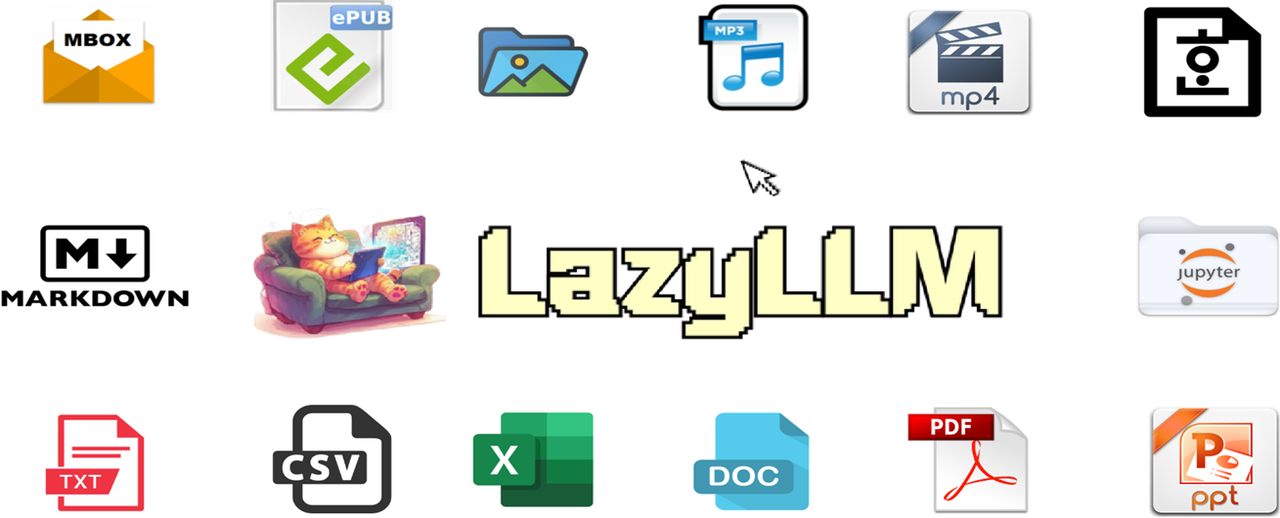

对于一些 LazyLLM 中 Reader 没有支持的文档格式，或者 LazyLLM 中 Reader 输出的格式不符合自己需求的话，我们就可以根据实际需求来定义一个满足自己需求的 Reader，然后让 LazyLLM 来使用即可。这里我们假设我们知识库中存在 html 格式的文档，以一个网页为例进行说明，网页数据为

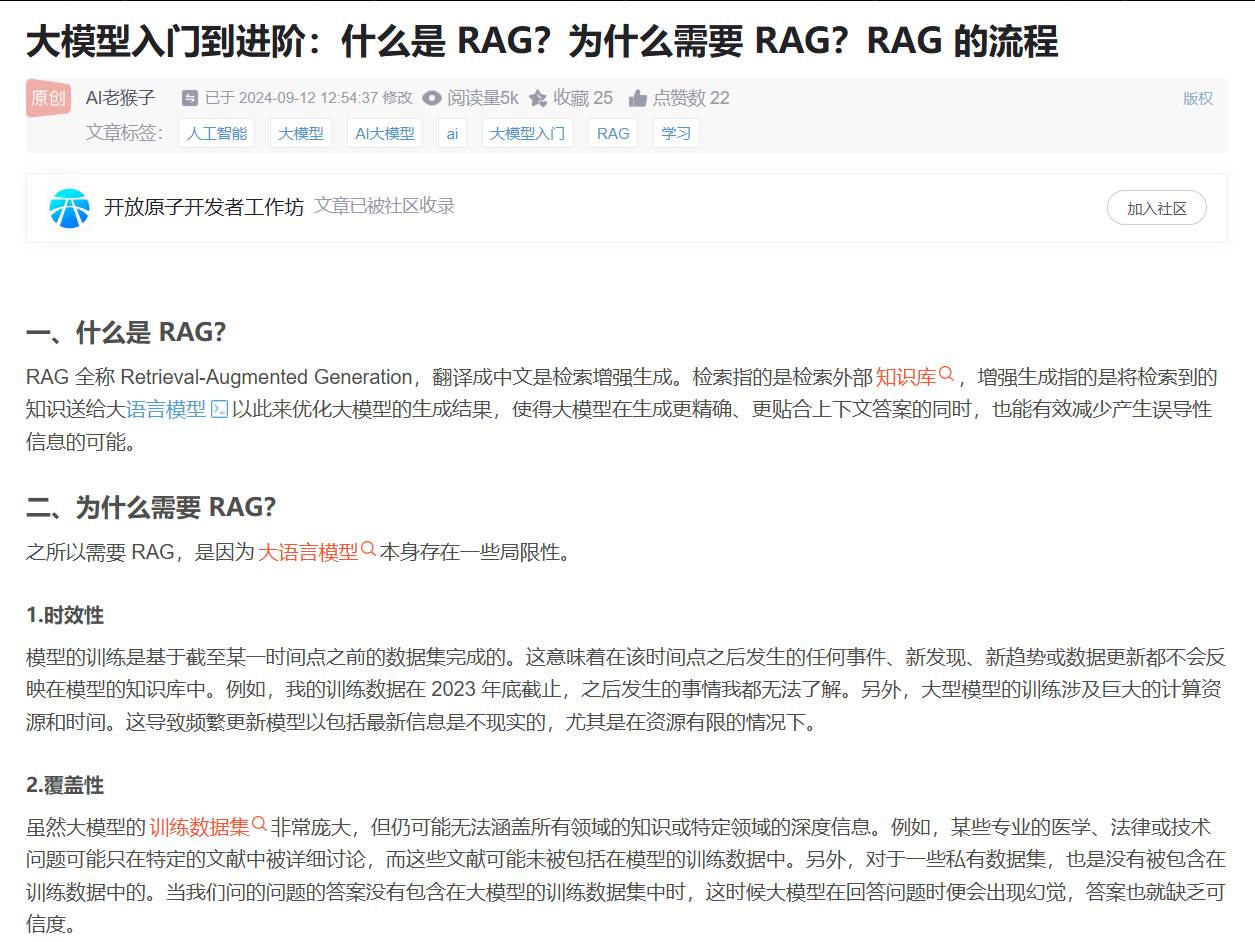

我们首先需要把当前网页数据保存成html格式文件，我们可以手动进行数据保存，也可以通过代码进行保存。下面代码为我们把网页数据保存文件的过程。

In [ ]:
import requests
# 当前网页url
url = "https://blog.csdn.net/star_nwe/article/details/141174167"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers)
if response.status_code == 200:
    with open("webPage.html", "w", encoding='utf-8') as file:
        file.write(response.text)
    print("Webpage downloaded successfully!")
else:
    print(f"Failed to download webpage. Status code: {response.status_code}")

通过运行上面的代码可以在**当前目录**中生成一个 webPage.html 的文件。

我们先看一下如果使用 LazyLLM 中默认的 Reader 解析出来是什么内容，使用方式和上一节中的一样：

[代码GitHub链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter5/reader_limitation.py#L1)

In [ ]:
from lazyllm.tools.rag import Document

doc = Document(dataset_path="your_doc_path")

data = doc._impl._reader.load_data(input_files=["webPage.html"])
print(f"data: {data}")
print(f"text: {data[0].text}")

首先 Reader 输出结果还是和上面一样，是一个 list 类型，然后里面的元素是一个 Node 类型的元素。

```bash
data: [<Node id=07fac8cb-5857-49cc-afc1-5c19bf83f636>]
```

然后我们看看 Node 中文本的信息，发现和我们的预期差别很大，里面除了网页的内容之外，还包括 html 里的各种标签。而我们预期的是 Reader 解析出来的数据应该只是网页上文字，而不应该包含 html 的标签。下面显示部分文本内容：

**text:**

```bash
<!DOCTYPE html>
<html lang="zh-CN">

<head>
    <meta charset="utf-8">
    <link rel="canonical" href="https://blog.csdn.net/star_nwe/article/details/141174167"/>
    <meta http-equiv="content-type" content="text/html; charset=utf-8">
    <meta name="renderer" content="webkit"/>
    <meta name="force-rendering" content="webkit"/>
    <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1"/>
    <meta name="viewport" content="width=device-width, initial-scale=1.0, minimum-scale=1.0, maximum-scale=1.0, user-scalable=no">
    <meta name="report" content='{"pid": "blog", "spm":"1001.2101"}'>
    <meta name="referrer" content="always">
    <meta http-equiv="Cache-Control" content="no-siteapp" /><link rel="alternate" media="handheld" href="#" />
    <meta name="shenma-site-verification" content="5a59773ab8077d4a62bf469ab966a63b_1497598848">
    <meta name="applicable-device" content="pc">
    <link  href="https://g.csdnimg.cn/static/logo/favicon32.ico"  rel="shortcut icon" type="image/x-icon" />
    <title>大模型入门到进阶：什么是 RAG？为什么需要 RAG？RAG 的流程-CSDN博客</title>
    <script>
      (function(){
        var el = document.createElement("script");
        el.src = "https://s3a.pstatp.com/toutiao/push.js?1abfa13dfe74d72d41d83c86d240de427e7cac50c51ead53b2e79d40c7952a23ed7716d05b4a0f683a653eab3e214672511de2457e74e99286eb2c33f4428830";
        el.id = "ttzz";
        var s = document.getElementsByTagName("script")[0];
        s.parentNode.insertBefore(el, s);
      })(window)
    </script>
        <meta name="keywords" content="rag">
        <meta name="csdn-baidu-search"  content='{"autorun":true,"install":true,"keyword":"rag"}'>
    <meta name="description" content="文章浏览阅读2.1w次，点赞34次，收藏74次。学习AI大模型是一个系统的过程，需要从基础开始，逐步深入到更高级的技术。这里给大家精心整理了一份全面的AI大模型学习资源，包括：AI大模型全套学习路线图（从入门到实战）、精品AI大模型学习书籍手册、视频教程、实战学习等录播视频，免费分享！_rag">
        <link rel="stylesheet" type="text/css" href="https://csdnimg.cn/release/blogv2/dist/pc/css/detail_enter-097f33faa6.min.css">
    <style>
        #content_views pre{
            -webkit-touch-callout: none;
            -webkit-user-select: none;
            -khtml-user-select: none;
            -moz-user-select: none;
            -ms-user-select: none;
            user-select: none;
        }
        #content_views pre code{
            -webkit-touch-callout: none;
            -webkit-user-select: none;
            -khtml-user-select: none;
            -moz-user-select: none;
            -ms-user-select: none;
            user-select: none;
        }
    </style>
    <script type="application/ld+json">{"@context":"https://ziyuan.baidu.com/contexts/cambrian.jsonld","@id":"https://blog.csdn.net/star_nwe/article/details/141174167","appid":"1638831770136827","pubDate":"2024-08-13T21:20:50","title":"大模型入门到进阶：什么是 RAG？为什么需要 RAG？RAG 的流程-CSDN博客","upDate":"2024-08-14T09:49:08"}</script>
        <link rel="stylesheet" type="text/css" href="https://csdnimg.cn/release/blogv2/dist/pc/themesSkin/skin-1024/skin-1024-ecd36efea2.min.css">
    <script src="https://g.csdnimg.cn/lib/jquery/1.12.4/jquery.min.js" type="text/javascript"></script>
    <script src="https://g.csdnimg.cn/lib/jquery-migrate/1.4.1/jquery-migrate.js" type="text/javascript"></script>
    <script type="text/javascript">
        var isCorporate = false;
        var username =  "star_nwe";
        var skinImg = "white";

        var blog_address = "https://blog.csdn.net/star_nwe";
        var currentUserName = "";
        var isOwner = false;
        var loginUrl = "http://passport.csdn.net/account/login?from=https://blog.csdn.net/star_nwe/article/details/141174167";
        var blogUrl = "https://blog.csdn.net/";
        var avatar = "https://profile-avatar.csdnimg.cn/9d615c5dd45743bea262227ce1ce205e_star_nwe.jpg!1";
        var articleTitle = "大模型入门到进阶：什么是 RAG？为什么需要 RAG？RAG 的流程";
        var articleDesc = "文章浏览阅读2.1w次，点赞34次，收藏74次。学习AI大模型是一个系统的过程，需要从基础开始，逐步深入到更高级的技术。这里给大家精心整理了一份全面的AI大模型学习资源，包括：AI大模型全套学习路线图（从入门到实战）、精品AI大模型学习书籍手册、视频教程、实战学习等录播视频，免费分享！_rag";
        var articleTitles = "大模型入门到进阶：什么是 RAG？为什么需要 RAG？RAG 的流程-CSDN博客";
        var nickName = "大模型微调部署";
        var articleDetailUrl = "https://blog.csdn.net/star_nwe/article/details/141174167";
        var vipUrlV = "https://mall.csdn.net/vip?vipSource=learningVip";
        if(window.location.host.split('.').length == 3) {
            blog_address = blogUrl + username;
        }
        var skinStatus = "White";
        var blogStaticHost = "https://csdnimg.cn/release/blogv2/"
          var payColumn = false
    </script>
```

## 自定义 Reader 读 HTML

[完整GitHub代码链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter5/rag_html_reader.py#L1)

#### 定义html读取函数

既然 LazyLLM 默认的 Reader 不能满足我们的需求，那我们就需要定义一个我们自己的 Reader。因为解析 html 格式的文档时，需要使用 lxml 工具包，所以需要先安装这个工具包，安装命令如下：

In [ ]:
pip install lxml

安装完 lxml 之后，就可以定义 Reader 了。

In [ ]:
from lazyllm.tools.rag import DocNode
from bs4 import BeautifulSoup

def processHtml(file, extra_info=None):
    text = ''
    with open(file, 'r', encoding='utf-8') as f:
        data = f.read()
        soup = BeautifulSoup(data, 'lxml')
        for element in soup.stripped_strings:
            text += element + '\n'
    node = DocNode(text=text, metadata=extra_info or {})
    return [node]

我们先使用 BeautifulSoup 包对网页内容解析，把解析出来的文本再通过 DocNode 类实例化成一个 node 对象，然后再以 list 的格式返回，这样可以和 LazyLLM 内部的 Reader 返回类型一致。

#### 注册函数到reader中


上面我们定义好了满足需求的 Reader，我们要怎么能让 LazyLLM 使用我们自定义的 Reader 呢？答案是我们需要把定义好的 Reader 注册进 LazyLLM，然后 LazyLLM 就可以使用我们自定义的 Reader 了。

因为 Reader 是在 Document 类里面，所有需要把自定义的 Reader 注册进 Document 里面。和前面一样，我们先实例化一个 Document 对象。

In [ ]:
from lazyllm.tools.rag import Document

doc = Document(dataset_path="your_doc_path")

然后通过调用 `add_reader` 成员函数把自定义的 `processHtml` 注册到 doc 上:

In [ ]:
doc.add_reader("*.html", processHtml)

这里需要注意，`add_reader` 函数接收两个参数，第一个是用于指定注册的 Reader 适用的匹配规则，类型是字符串类型。这里传的匹配规则是"\*.html"，表示需要处理的文档是当前目录下以 "html" 为后缀的所有文档。第二个是自定义的 Reader，它必须是 Callable 的对象。

#### 效果展示


上面我们自定义好了 Reader，并且也注册进了 Document 实例里，下面我们看下自定义的 Reader 怎么使用以及效果怎么样？

我们把上面的代码整合一下，如下：

In [ ]:
from lazyllm.tools.rag import Document

doc = Document(dataset_path="your_doc_path")
doc.add_reader("*.html", processHtml)
data = doc._impl._reader.load_data(input_files=["webPage.html"])
print(f"data: {data}")
print(f"text: {data[0].text}")

可以看到，上面的代码和之前使用 Reader 的代码唯一的区别就是多了第4行的注册代码，其他都没有变化。那我们看看输出结果有没有变化呢？

```bash
data: [<Node id=7b5ee92a-b28c-4a6b-a71e-ef4f773965b0>]
```

首先，我们看到 Reader 的输出还是 list 类型，然后里面的元素是 Node 类型的元素，没有变化，这是符合预期的。然后我们再看一下 Node 里面的部分文本内容：

```bash
text: 大模型入门到进阶：什么是 RAG？为什么需要 RAG？RAG 的流程-CSDN博客
大模型入门到进阶：什么是 RAG？为什么需要 RAG？RAG 的流程
置顶
大模型微调部署
已于 2024-09-12 12:54:37 修改
阅读量2.1w
收藏
74
点赞数
                            34
文章标签：
人工智能
大模型
AI大模型
ai
大模型入门
RAG
学习
于 2024-08-14 09:49:08 首次发布
版权声明：本文为博主原创文章，遵循
CC 4.0 BY-SA
版权协议，转载请附上原文出处链接和本声明。
本文链接：
https://blog.csdn.net/star_nwe/article/details/141174167
版权
一、什么是 RAG？
RAG 全称 Retrieval-Augmented Generation，翻译成中文是检索增强生成。检索指的是检索外部知识库，增强生成指的是将检索到的知识送给大语言模型以此来优化大模型的生成结果，使得大模型在生成更精确、更贴合上下文答案的同时，也能有效减少产生误导性信息的可能。
二、为什么需要 RAG？
之所以需要 RAG，是因为大语言模型本身存在一些局限性。
1.时效性
模型的训练是基于截至某一时间点之前的数据集完成的。这意味着在该时间点之后发生的任何事件、新发现、新趋势或数据更新都不会反映在模型的知识库中。例如，我的训练数据在 2023 年底截止，之后发生的事情我都无法了解。另外，大型模型的训练涉及巨大的计算资源和时间。这导致频繁更新模型以包括最新信息是不现实的，尤其是在资源有限的情况下。
2.覆盖性
虽然大模型的训练数据集非常庞大，但仍可能无法涵盖所有领域的知识或特定领域的深度信息。例如，某些专业的医学、法律或技术问题可能只在特定的文献中被详细讨论，而这些文献可能未被包括在模型的训练数据中。另外，对于一些私有数据集，也是没有被包含在训练数据中的。当我们问的问题的答案没有包含在大模型的训练数据集中时，这时候大模型在回答问题时便会出现幻觉，答案也就缺乏可信度。
由于以上的一些局限性，大模型可能会生成虚假信息。为了解决这个问题，需要给大模型外挂一个知识库，这样大模型在回答问题时便可以参考外挂知识库中的知识，也就是 RAG 要做的事情。
三、RAG 的流程
RAG 的中文名称是检索增强生成，从字面意思来理解，包含三个检索、增强和生成三个过程。
```

通过上面的结果显示，我们使用自定义 Reader 对 html 格式的文档进行解析，得到的结果是符合我们的预期的，因为结果里面已经不包含 html 的各种标签了。

## 构建基于 HTML 文档的 RAG 应用


上面我们讲了很多关于如何定义符合自己需求的 Reader。接下来我们基于上面定义的解析 html 的 Reader来实现一个简单的 RAG 应用，看看自定义 Reader的效果。

首先我们使用默认的 Reader 来处理 html 文档，看看 RAG 的效果。这里我们使用的时智普平台的模型为例来说明，我们先定义一个合适的 prompt：

In [ ]:
prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task. In this task, you need to provide your answer based on the given context and question.'

然后定义 Document 对象，来管理知识库

In [ ]:
import os
import lazyllm
from lazyllm.tools.rag import Document
from lazyllm import SentenceSplitter

documents = Document(dataset_path=os.path.join(os.getcwd(), "rag_data"), embed=lazyllm.OnlineEmbeddingModule(source="glm", embed_model_name="embedding-2"), manager=False)
documents.create_node_group(name="sentences", transform=SentenceSplitter, chunk_size=1024, chunk_overlap=100)

其中 “os.path.join(os.getcwd(), "rag\_data")” 用来指定知识库需要用的数据路径，这里必须使用绝对路径。这个数据集下包含的文档为：[hongkong.htl  housing.html  national\_health\_insurance\_administration.html  rag.html  taiwan.html](https://huggingface.co/datasets/LazyAGI/Html_Knowledge_Base/tree/main)。然后定义对文档的处理方式，这里选择的是对文档按句子进行切分处理。

下面开始定义 RAG 的处理流程

In [ ]:
import lazyllm
from lazyllm import pipeline, parallel, Retriever, Reranker, bind

with pipeline() as ppl:
    with parallel().sum as ppl.prl:
        prl.retriever1 = Retriever(documents, group_name="sentences", similarity="cosine", topk=3)
        prl.retriever2 = Retriever(documents, "CoarseChunk", "bm25_chinese", 0.003, topk=3)
    ppl.reranker = Reranker("ModuleReranker", model=lazyllm.OnlineEmbeddingModule(type="rerank", source="glm", embed_model_name="rerank"), topk=1, output_format='content', join=True) | bind(query=ppl.input)
    ppl.formatter = (lambda nodes, query: dict(context_str=nodes, query=query)) | bind(query=ppl.input)
    ppl.llm = lazyllm.OnlineChatModule(source='glm', model="glm-4", stream=False).prompt(lazyllm.ChatPrompter(prompt, extra_keys=["context_str"]))

首先定义了两个 retriever，一个是通过 cosine 来检索相关文档，一个是通过 bm25 来检索相关文档。然后定义 reranker (用于创建节点（文档）后处理和重排序的模块。参数包含​`name` 和 `kwargs`​。​`name`用于后处理和重排序过程的排序器类型，默认为 `ModuleReranker`，排序器类型目前支持 `ModuleReranker` 和 `KeywordFilter`。`ModuleReranker `实例化一个具有指定模型和 top\_n 参数的 SentenceTransformerRerank 重排序器。`KeywordFilter`实例化一个具有指定必需和排除关键字的 KeywordNodePostprocessor。它根据这些关键字的存在或缺失来过滤节点。`kwargs`传递给重新排序器实例化的其他关键字参数，来对前面检索出的文档进行重排序。接下来定义了一个formatter，用来处理检索到的 node 信息和相关 query 的关系。最后定义 LLM，来处理检索到的文档信息并生成最后的答案。最后即通过调用 ppl 来处理对应的 query 即可完成基于网页知识库的对话机器人。

我们以下面这篇文章为例子进行提问。

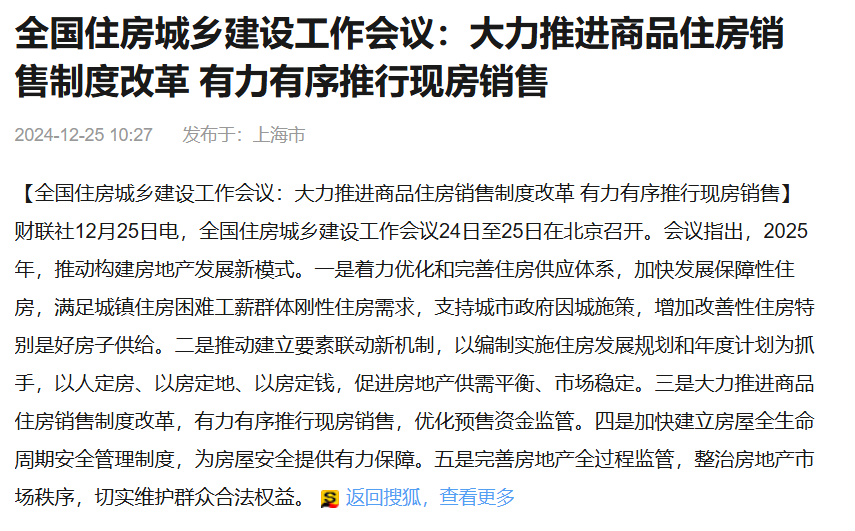

请求代码如下：

In [ ]:
print(ppl("全国住房城乡建设工作会议的主要内容"))

输出的内容为:

```bash
全国住房城乡建设工作会议主要内容包括以下几个方面：

1. 会议提出，2025年将推动构建房地产发展新模式。

2. 着力优化和完善住房供应体系，加快发展保障性住房，满足城镇住房困难工薪群体刚性住房需求。

3. 支持城市政府因城施策，增加改善性住房特别是好房子的供给。

4. 推动建立要素联动新机制，以编制实施住房发展规划和年度计划为抓手，实现人定房、以房定地、以房定钱，促进房地产供需平衡、市场稳定。

5. 大力推进商品住房销售制度改革，有力有序推行现房销售，优化预售资金监管。

6. 加快建立房屋全生命周期安全管理制度，为房屋安全提供有力保障。

这些内容旨在解决当前房地产市场中存在的问题，如供需不平衡、市场波动等，以实现房地产市场的稳定和健康发展。
```

接下来我们把前面我们自定义的处理 html 格式的 Reader 加入进来，看看效果：

In [ ]:
documents = Document(dataset_path=os.path.join(os.getcwd(), "rag_data"), embed=lazyllm.OnlineEmbeddingModule(source="glm", embed_model_name="embedding-2"), manager=False)
documents.add_reader("*.html", processHtml)
documents.create_node_group(name="sentences", transform=SentenceSplitter, chunk_size=1024, chunk_overlap=100)
with pipeline() as ppl:
    with parallel().sum as ppl.prl:
        prl.retriever1 = Retriever(documents, group_name="sentences", similarity="cosine", topk=3)
        prl.retriever2 = Retriever(documents, "CoarseChunk", "bm25_chinese", 0.003, topk=3)
    ppl.reranker = Reranker("ModuleReranker", model=lazyllm.OnlineEmbeddingModule(type="rerank", source="glm", embed_model_name="rerank"), topk=1, output_format='content', join=True) | bind(query=ppl.input)
    ppl.formatter = (lambda nodes, query: dict(context_str=nodes, query=query)) | bind(query=ppl.input)
    ppl.llm = lazyllm.OnlineChatModule(source='glm', model="glm-4", stream=False).prompt(lazyllm.ChatPrompter(prompt, extra_keys=["context_str"]))

输出内容为：

```bash
全国住房城乡建设工作会议主要聚焦于推进房地产市场的改革和发展。根据您提供的文本内容，会议的主要内容包括：

1. **优化住房供应体系**：加快发展保障性住房，满足城镇住房困难群体的刚性需求，支持各城市政府根据本地实际情况制定相应政策，增加改善性住房的供给，特别是高品质住宅。

2. **建立要素联动新机制**：通过编制和实施住房发展规划及年度计划，实现人口、住房和土地供应的联动，促进房地产市场的供需平衡和市场稳定。

3. **改革商品住房销售制度**：会议强调大力推进商品住房销售制度的改革，有序推行现房销售，同时优化预售资金监管，以降低市场风险，保障消费者权益。

4. **建立房屋全生命周期安全管理制度**：加强对房屋从建设到使用的全过程安全管理，确保房屋安全。

5. **完善房地产全过程监管**：对房地产市场进行全过程监管，规范市场秩序，打击违法违规行为，保护群众合法权益。

这些措施旨在推动构建房地产发展的新模式，确保房地产市场的平稳健康发展，同时更好地满足人民群众的住房需求。
```

通过对上面两种情况的输出结果进行比较可以发现，使用自定义 Reader 的效果更好一些，给出的答案也更贴合原文。

**注意：由于在线模型每次输出的结果都会有变化，不能保证每次输出的内容都和上面的完全一样。但是经过多次测试发现，使用自定义 Reader 的效果还是会比使用默认 Reader 的情况要好一些。所以针对具体的需求，定义合适的 Reader 还是对 RAG 的效果有一定帮助的。**

## 深度阅读：多级 Reader 注册


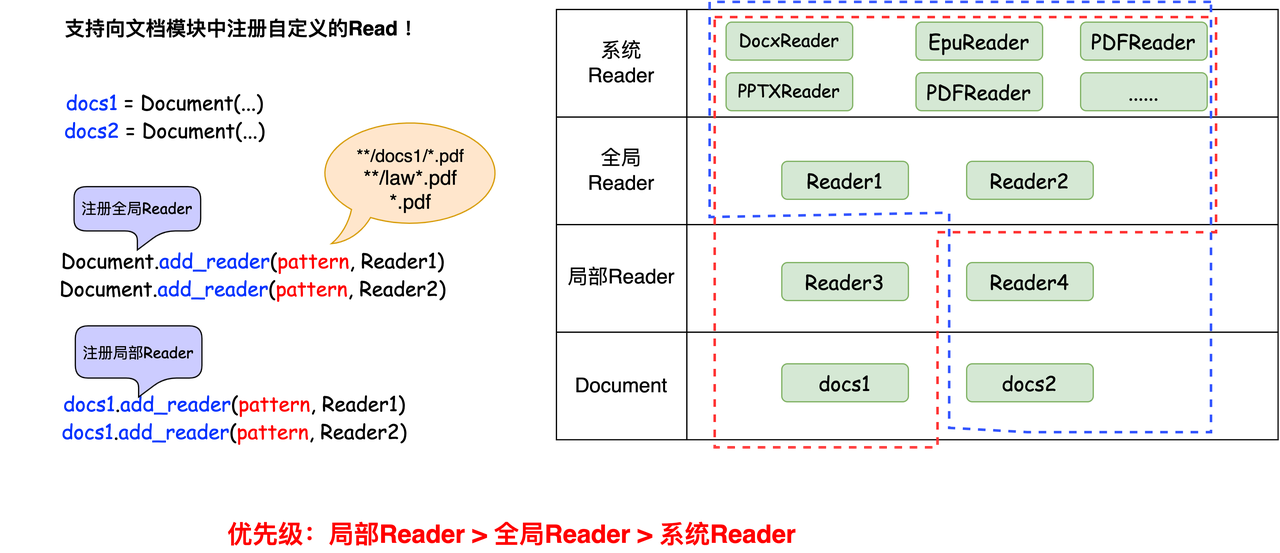

前面我们再讲 Reader 的注册方式没有深入讲解，这里我们将更深入的讲解一下。

Reader 是通过 key - value 的方式进行注册，key 是用来说明 Reader 可以处理的数据格式，可以是直接指定对应的文件，也可以指定 Reader 要处理的数据模式，即可以使用通配符 `*` 来指定匹配规则，例如 “\*.html” 表示可以处理任何以 “html” 为后缀的文件，“aaa/bbb/\*.html” 表示要处理的是“aaa/bbb”目录下的任何以 “html” 为后缀的文件，“aaa/bbb/\*\*/\*.html” 表示要处理的是“aaa/bbb”目录下**所有目录**中任何以“html”为后缀的文件。value 就是对应的 Reader。

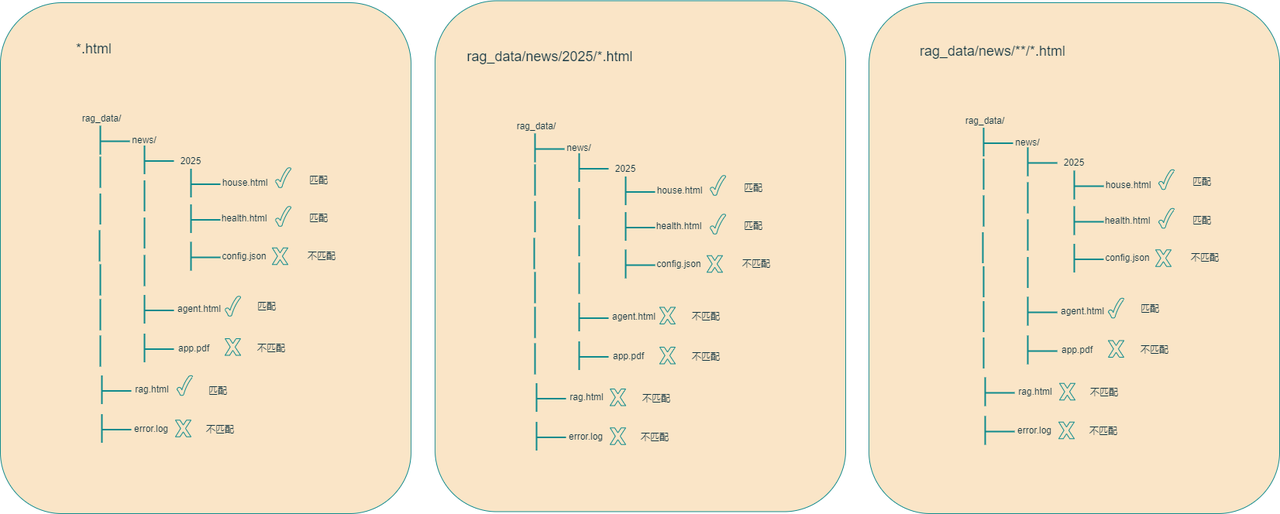

讲完了注册规则，我们再来讲一下注册方式。

LazyLLM 中 Reader 的注册机制分为两种不同的方式，一种是通过 Document 类进行注册，注册完之后，使用 Document 类实例化的对象都可以使用该 Reader，另一种是通过 Document 类的实例化对象进行注册(这是前面讲的注册方式)，注册完之后，只有该对象可以使用该 Reader，其他的 Document 类的实例化对象因为对该 Reader 不可见，则不能使用该 Reader。所以对于 LazyLLM 中的 Reader 的优先级从高到低为“通过对象注册的 Reader”>“通过类注册的Reader”>“LazyLLM 默认提供的 Reader”，如果匹配规则是一样的话，就会按照优先级顺序，优先级高的 Reader 会覆盖掉 优先级低的 Reader。

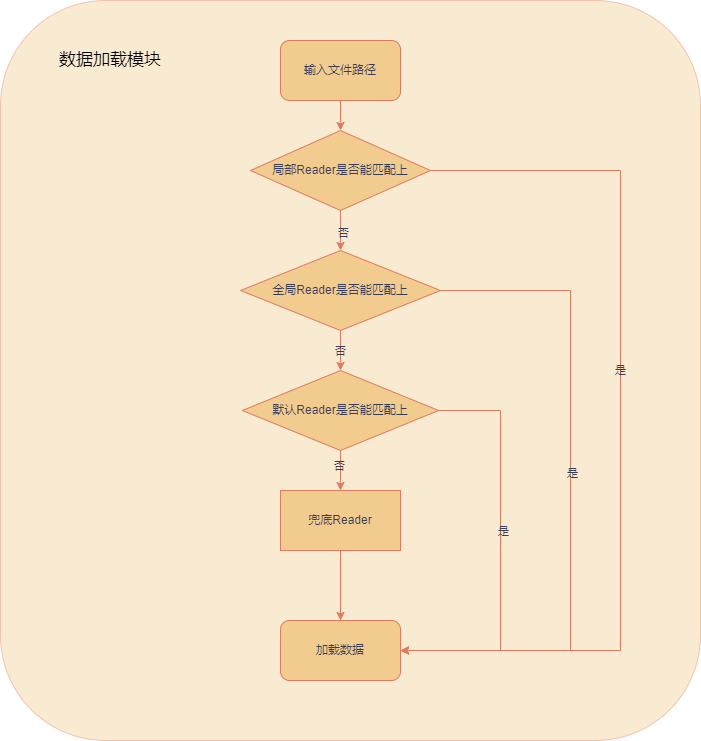

全局 Reader 注册的方法如下：

In [ ]:
from lazyllm.tools.rag import Document

Document.register_global_reader("*.html", processHtml)
Document.register_global_reader("aa/*.html", HtmlReader)
Document.register_global_reader("aa/**/*.html", UnionPdfReader)

## 基于类来自定义 Reader

[完整GitHub代码链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter5/reader_class.py#L1)


但是当 Reader 需要在多个调用之间保持状态（如缓存、计数器、连接池等）或者需要在初始化时进行复杂的对象创建（如数据库连接、模型加载等）以及解析过程复杂，需要拆分多个方法的。这时再使用函数的形式就就不合适了。我们就得使用基于类的方式来定义 Reader 了。并且因为 `Reader` 有不同类型的子类，所以基于类的形式可以扩展不同类型的解析器

#### 定义个类

这里我们以一个给图片提取摘要的例子来说明，因为这个 Reader 需要使用到 `torch`、`transformers`、`sentencepiece`和`Pillow`库，如果环境中没有需要提前安装，安装命令如下：

In [ ]:
pip install torch transformers sentencepiece Pillow

然后我们开始定义我们需要的 Reader，因为这个 Reader 需要导入模型，所以需要把模型加载放到初始化函数中，这样在多次使用时，就不用每次都加载一遍了，这种情况明显定义函数是不合适的。

In [ ]:
from lazyllm.tools.rag.readers import ReaderBase
from lazyllm.tools.rag.readers.readerBase import infer_torch_device
from lazyllm.tools.rag import DocNode
from pathlib import Path
from typing import Optional, Dict, List
from PIL import Image
from transformers import BlipForConditionalGeneration, BlipProcessor
import torch

class ImageDescriptionReader(ReaderBase):
    def __init__(self, parser_config: Optional[Dict] = None, prompt: Optional[str] = None) -> None:
        super().__init__()
        if parser_config is None:

            device = infer_torch_device()
            dtype = torch.float16 if torch.cuda.is_available() else torch.float32
            processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
            model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large", torch_dtype=dtype)
            parser_config = {"processor": processor, "model": model, "device": device, "dtype": dtype}
        self._parser_config = parser_config
        self._prompt = prompt

    def _load_data(self, file: Path, extra_info: Optional[Dict] = None) -> List[DocNode]:
        image = Image.open(file)
        if image.mode != "RGB":
            image = image.convert("RGB")

        model = self._parser_config['model']
        processor = self._parser_config["processor"]

        device = self._parser_config["device"]
        dtype = self._parser_config["dtype"]
        model.to(device)

        inputs = processor(image, self._prompt, return_tensors="pt").to(device, dtype)

        out = model.generate(**inputs)
        text_str = processor.decode(out[0], skip_special_tokens=True)
        return [DocNode(text=text_str, metadata=extra_info or {})]

首先需要导入 `ReaderBase` 基类，然后自定义的 Reader 要继承自该基类，并重新实现 `_load_data` 接口，其他复杂的功能可以在类中其他的成员函数中实现即可。

> ​注意：class 里面定义的 ​*​*`_load_data`*​*​ 接口和上面使用 Reader 时调用的 ​*​*`load_data`*​​*​ 接口完全没关系啊。class 里面的 ​*​*`_load_data`*​*​ 接口是每个 Reader 类中重载基类中的接口。而前面使用 Reader 时，调用的 ​*​*`load_data`*​*​ 接口是对文件列表进行遍历解析的接口。

#### 注册该类

前面介绍了基于函数的 Reader 注册，基于类的 Reader 注册和前面的相同，也是通过 `Document` 类的成员函数 `add_reader` 进行注册。第一个参数同样是 Reader 适用的匹配规则，类型是字符串类型，第二个参数是自定义的类名，必须是Callable的对象。

In [ ]:
from lazyllm.tools.rag import Document
doc = Document(dataset_path="your_doc_path")
doc.add_reader("*.jpg", ImageDescriptionReader)
doc.add_reader("*.png", ImageDescriptionReader)
doc.add_reader("*.jpeg", ImageDescriptionReader)

从代码中可以看出和基于函数的 Reader 注册方法的区别仅仅是用类名替换了前面的函数名。

#### 效果展示


前面我们定义好基于类的 Reader，并注册进 `Document` 实例中，然后我们使用[ LazyLLM](https://github.com/LazyAGI/LazyLLM) 的 "[LazyLLM-logo.png](https://raw.githubusercontent.com/LazyAGI/LazyLLM/main/docs/assets/LazyLLM-logo.png)"图片来测试，图片内容为：

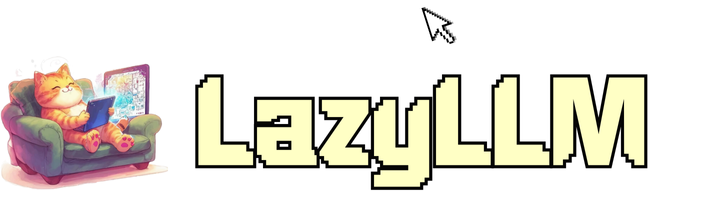

In [ ]:
from lazyllm.tools.rag import Document

doc = Document(dataset_path="your_doc_path")
doc.add_reader("*.png", ImageDescriptionReader)
data = doc._impl._reader.load_data(input_files=["cmrc2018_path/LazyLLM-logo.png"])
print(f"data: {data}")
print(f"text: {data[0].text}")

首先 Reader 的输出还是 list 类型，而其中的元素则是 Node 类型，符合预期。

```bash
data: [<Node id=0d1d9eb5-f3c3-47d9-8ccc-4f6ec834a276>]
```

而 Node 中的文本内容，生成的图片描述文本内容，也符合预期。

```bash
text: a close up of a cat sitting on a chair next to a computer
```

## 定义复杂 Reader 读 PDF

#### 当前 Reader 的不足

前面我们通过以 html 格式文档为例，介绍了怎么自定义 Reader，以及怎么注册和使用。相对来说上面自定义的 Reader 功能比较简单。这一节我们介绍怎么自定义一个复杂且实用的 Reader。

我们在平时的工作中用到的 pdf 格式的文档还是比较多，并且 pdf 格式的文档存储的数据是非结构化的。我们一般都是通过开源工具来解析 pdf 文档的。这里我们以[《平安证券-珀莱雅.pdf》](https://huggingface.co/datasets/LazyAGI/PDF_Parsing_for_Business_Documents_Demo/tree/main)这篇文章为例，LazyLLM 中的 `PDFReader` 是默认使用 pypdf 包来解析 pdf 格式文件的。我们先看一下使用 LazyLLM 默认提供的 `PDFReader` 解析的效果。解析代码为[GitHub链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter5/reader_insufficient.py#L1):

In [ ]:
from lazyllm.tools.rag import Document

doc = Document(dataset_path="your_doc_path")

data = doc._impl._reader.load_data(input_files=["平安证券-珀莱雅.pdf"])
print(f"data: {data}")
print(f"text: {data[0].text}")

**这里需要注意，论文存放的路径是当前目录下，如果不是当前目录，需要给出相对路径或者绝对路径。**

```bash
data: [<Node id=b21463fd-b2f8-49b8-a582-04eda7a8e302>, <Node id=60f7824d-d181-4a40-942e-b8031cc99c99>, <Node id=b1a52046-483a-43da-b6de-07591fdfcf74>, <Node id=8a625cfb-397d-4799-a33a-9c5439a53dac>]
```

我们先看 Reader 输出的内容，结果是 list 类型，其中有4个 Node 类型的元素，而这篇论文一共有4页，正好对应这4个 Node 类型的元素。

```bash
text: 社会服务  
2024年10月29日 
珀莱雅 (603605.SH)  
高质量稳健增长，双十一稳定发挥  
  
请通过合法途径获取本公司研究报告，如经由未经许可的渠道获得研究报告，请慎重使用并注意阅读研究报告尾页的声明内容。   
 
公
司
报
告 
公
司
季
报
点
评 
  
推荐（维持）  
股价： 96.75元 
主要数据    
行业 社会服务  
公司网址  www.proy a -group.com  
大股东 /持股 侯军呈 /34.46%  
实际控制人  侯军呈 ,方爱琴  
总股本 (百万股 ) 396 
流通 A股(百万股 ) 395 
流通 B/H股(百万股 )  
总市值（亿元）  383 
流通 A股市值 (亿元) 382 
每股净资产 (元) 12.09  
资产负债率 (%) 34.2 
 
行情走势图   
 
相关研究报告   
【平安证券】珀莱雅（ 603605.SH ）*事项点评 *H1经营
稳健，管理层换届 *推荐20240913  
【平安证券】珀莱雅（ 603605.SH ）*首次覆盖报告 *大
单品奠基，敏锐洞察 +敏捷执行，持续突破 **推荐
20240518  
证券分析师      
胡琼方  投资咨询资格编号  
 S1060524010002  
 HUQIONGFANG722@pingan.com.cn   
 事项：  
公司 2024前三季度实现营收 69.66亿元 (+32.72%) ，归母净利润同比增长
33.95%至9.99亿元。 扣除非经常性损益后为 9.71亿元(+33.81%) 。eps（基本）
=2.53元。毛利率为 70.07%( -1.11pct)，净利率为 14.68%( -0.09pct)，销售费用
同比（下同） +42.29% 至32.32亿元，销售费用率 46.39%，+3.12 pct ；管理
费用-4.88%至2.73亿元，管理费用率 3.91%，-1.55 pct；研发费用 1.42亿元，
研发费用率 2.04%，-0.41 pct；财务费用率 -0.57%，+0.26 pct 。 
单季度营收同比增长 21.15%至19.65亿元，归母净利润同比增长 20.72%至
2.98亿元。  
平安观点：  
 在美妆整体经营弱化的环境下，公司 Q3获得高质量的稳健增长，业绩符
合预期。根据国家统计局，社零中化妆品类 1-9月零售额同比 -1%至3069
亿元，而公司三季度获得双 20%+的收入和归母净利润增速，持续稳健增
长。同时三季 度公司毛销差相较上半年有所优化，其中 H1毛利率为
69.82%，Q3单季度为 70.71%（同比 -1.95pct） ，上半年销售费用率为
46.78%，Q3单季度为 45.40%（较上年同期 +2.78pct ） ；单季度净利率为
15.19%（同比 -0.02pct）。 
  步入 Q4后，今年各电商平台双十一战线拉长，美妆品牌竞争较为激烈，
公司旗下品牌表现亮眼。根据天猫大美妆官方公众号，天猫抢先购（ 10
月21日20:00 -10月23日24:00）快消榜珀莱雅品牌排第一名，第二和
第三分别为巴黎欧莱雅和兰蔻；美妆榜珀莱雅同样排名第一 ，第二和第三
分别为兰蔻和巴黎欧莱雅。 此前的天猫美妆预售阶段 （ 10月14日20:00 -10
月17日24:00） ，巴黎欧莱雅和修丽可位列第二、第三。   
 投资建议： 美妆行业增速放缓， 同时竞争激烈， 公司继续坚持大单品策略，
以优质产品和运营抢占市场份额，获得稳健地高质量增长，且在截止目前
的双十一销售中稳定发挥。 我们维持对公司 2024 -2025年的业绩 预测，并
略调整 2026年预测， 2024 -2026年对应归母净利润分别为 15.52、19.03、
23.08亿元（2026年原预测为 23.09亿元），对应当前市值（ 2024 -10-28
市值）分别约 24.7、20.1和16.6倍PE。公司作为国货龙头，近年来形  
  
 2022A  2023A  2024E  2025E  2026E  
营业收入 (百万元 ) 6,385  8,905  11,492  13,897  16,560  
YOY(%)  37.8  39.5  29.1  20.9  19.2  
净利润 (百万元 ) 817  1,194  1,552  1,903  2,308  
YOY(%)  41.9  46.1  30.0  22.6  21.3  
毛利率 (%) 69.7  69.9  70.3  70.5  70.8  
净利率 (%) 12.8  13.4  13.5  13.7  13.9  
ROE(%)  23.2  27.4  28.9  28.7  28.4  
EPS(摊薄/元) 2.06  3.01  3.92  4.80  5.83  
P/E(倍) 46.9  32.1  24.7  20.1  16.6  
P/B(倍) 11.0  8.9  7.2  5.8  4.7   
证
券
研
究
报
告 
text: 珀莱雅·公司季报点评  
 
 
 
请通过合法途径获取本公司研究报告，如经由未经许可的渠道获得研究报告，请慎重使用并注意阅读研究报告尾页的声明内容。  2/ 4  
成了系统化、规范化、标准化 的运营体系，日益参与到与国 际美妆集团的竞争中，未来有望进一步获取更大的大众美妆
市场份额。目前公司估值水平处在历史中 低位区间，结合当前估值水平及市场环境情况，维持 “推荐”评级。   
 风险提示 ：1.宏观经济波动。宏观经济对美妆在内的可选消费有一定影响，若经济环境波动则影响消费意愿，进而进一
步对公司业绩造成不利影响。 2.管理层变动对组织带来一定扰动。公司董事会换届，管理层变动，若磨合、过渡进程不
及预期，则可能影响正常运营。 3.新产品推广不及预期、新品牌孵化不及预期，新渠道拓展不力等。行业变化相对较快，
如相关新渠道拓展或适应不及预期、新产品、 新品牌发展不力则影响公司成长。
```

我们可以看到论文第一、二页的文本内容都提取出来了，但是还有些问题，文本之间文表混合的样式，默认reader提取出来的内容就混乱了，不能保持语义的连贯性。这样的结果显然是不符合文本信息完整性的。

#### 引入高性能开源工具


针对上面的问题，我们可以找一些效果更好符合需求的开源工具接入进来。我们这里以 magic-pdf 工具为例进行介绍。

首先需要在当前的环境中安装 magic-pdf 工具包，安装命令为：

In [ ]:
pip install "magic-pdf[full]==1.0.1" --extra-index-url https://wheels.myhloli.com
# 由于依赖包新版本的更新可能会造成这个版本的 magic-pdf 安装比较费劲，我们推荐使用下面的方式安装
step1: pip install -r xxx.txt
xxx.txt内的内容：
git+https://github.com/facebookresearch/detectron2
boto3==1.28.43
Brotli==1.1.0
fast-langdetect==0.3.2
pdfminer.six==20231228
PyMuPDF==1.24.9
unimernet==0.2.1
ultralytics
paddleocr==2.7.3
paddlepaddle==3.0.0b1
pypandoc
struct-eqtable==0.1.0
doclayout-yolo==0.0.3
magic-pdf==1.0.1
pyopenssl==23.2.0
rapid_table==0.3.0
rapidocr_onnxruntime

step2: 安装triton
pip install triton==3.1.0

**NOTE:如果安装完成后，使用时报"ImportError: libGL.so.1: cannot open shared object file: No such file or directory"这个错误，有两种方式可以解决，一种是直接重新安装一下​`opencv-python-headless`​​包，​​二​是在系统中提前安装libGL.so.1，对于Ubuntu系统为例：需要安装apt-get install -y libgl1-mesa-glx或者apt install​​ -y​​ libgl1即可。**

**注意：这里指定了 magic-pdf 的版本为“1.0.1”。**

然后需要从 Hugging Face上下载模型权重文件，这里下载的模型权重文件是和上面版本的magic-pdf匹配的。下载命令为:

In [ ]:
pip install modelscope
wget https://gcore.jsdelivr.net/gh/opendatalab/MinerU@master/scripts/download_models.py -O download_models.py
python download_models.py
# 为了保证模型和 magic_pdf 版本的匹配，我们推荐从下面的链接下载模型，这是我们把相关的模型提前打包好了。
https://huggingface.co/LazyAGI/PDF-Extract-Kit/tree/main

处理完工具包和模型权重之后，就可以开始自定义我们的 pdfReader 了。因为这个 Reader 的实现比较复杂，因此这里选用的是基于 class 的 Reader。首先导入基类 `ReaderBase`和 `DocNode` ，然后配置 magic-pdf 的模型参数。

In [ ]:
from lazyllm.tools.rag.readers import ReaderBase
from lazyllm.tools.rag import DocNode

import torch
from magic_pdf.libs import config_reader

def read_config():
    config = {'bucket_info': {'bucket-name-1': ['ak', 'sk', 'endpoint'], 'bucket-name-2': ['ak', 'sk', 'endpoint']}, 'models-dir': '{model_path}/PDF-Extract-Kit-1___0/models', 'layoutreader-model-dir': '{model_path}/PDF-Extract-Kit-1___0/layoutreader', 'layout-config': {'model': 'layoutlmv3'}, 'formula-config': {'mfd_model': 'yolo_v8_mfd', 'mfr_model': 'unimernet_small', 'enable': False}, 'table-config': {'model': 'tablemaster', 'enable': True, 'max_time': 400}, 'config_version': '1.0.0'}
    config['device-mode'] = "cuda" if torch.cuda.is_available() else "cpu"
    return config

config_reader.read_config = read_config

然后就要定义我们 Reader 类，并实现基类的 `_load_data` 接口。

[完整GitHub代码链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter5/reader_magic_pdf.py#L49)

In [ ]:
from lazyllm.tools.rag import DocNode
from pathlib import Path
from typing import List, Optional
import copy

PARAGRAPH_SEP = "\n"

class UnionPdfReader(ReaderBase):
    def _load_data(self, file: Path, split_documents: Optional[bool] = True, extra_info=None, fs=None) -> List[DocNode]:
        if not isinstance(file, Path): file = Path(file)
        elements = self._pdf_parse_to_elements(file)
        docs = []
        if split_documents:
            for element in elements:
                metadata = copy.deepcopy(extra_info) or {}
                metadata["file_name"] = file.name
                for k, v in element.items():
                    if k == "text":
                        continue
                    metadata[k] = v
                docs.append(DocNode(text=element["text"] if "text" in element else "", metadata=metadata))
        else:
            metadata = extra_info or {}
            metadata["file_name"] = file.name
            text_chunks = [el["text"] for el in elements if "text" in el]
            docs.append(DocNode(text=PARAGRAPH_SEP.join(text_chunks), metadata=metadata))
        return docs

我们在上面的代码中假定 `self._pdf_parse_to_elements` 接口可以把 pdf 文档全部解析完，并返回一个字典类型对象。然后根据参数 `split_documents` 来决定是把 pdf 文档按页为单位分别处理成一个Node，还是把整个 pdf 文档内容当成一个 Node 返回。并且我们在元数据中增加了文件名称。

接着我们开始使用 magic-pdf 工具包来解析 pdf 文档了。下图是解析 pdf 文档的流程：

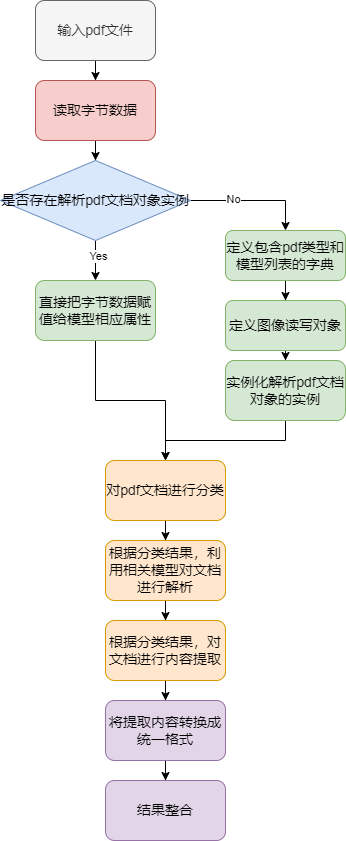

我们先实现使用 magic-pdf 解析 pdf 文档的主要流程:

In [ ]:
from lazyllm.tools.rag.readers import ReaderBase

from magic_pdf.data.data_reader_writer import FileBasedDataWriter, FileBasedDataReader
from magic_pdf.data.dataset import PymuDocDataset
from magic_pdf.model.doc_analyze_by_custom_model import doc_analyze
from magic_pdf.config.enums import SupportedPdfParseMethod
from magic_pdf.libs import config_reader

class UnionPdfReader(ReaderBase):
    def __init__(self):
        super().__init__()
        self.image_save_path = "Stored Images Path"
        self.model = None
    
    def _pdf_parse_to_elements(self, pdf_path: Path):
        # args
        image_dir = str(os.path.basename(self.image_save_path))

        os.makedirs(self.image_save_path, exist_ok=True)

        image_writer = FileBasedDataWriter(self.image_save_path)

        # read bytes
        reader1 = FileBasedDataReader("")
        pdf_bytes = reader1.read(pdf_path)  # read the pdf content

        # proc
        # Create Dataset Instance
        ds = PymuDocDataset(pdf_bytes)

        # inference
        if ds.classify() == SupportedPdfParseMethod.OCR:
            infer_result = ds.apply(doc_analyze, ocr=True)
            pipe_result = infer_result.pipe_ocr_mode(image_writer)

        else:
            infer_result = ds.apply(doc_analyze, ocr=False)

            pipe_result = infer_result.pipe_txt_mode(image_writer)

        infer_result.get_infer_res()

        content_list_content = pipe_result.get_content_list(image_dir)
        return self._result_extract(content_list_content)

在上面的代码中，我们现在初始化函数中定义了图片保存路径和模型变量。\_pdf\_parse\_to\_elements函数中定义了核心解析逻辑，先从传入的文件中读取二进制数据初始化为一个PymuDocDataset数据类型，然后调用自身的分类方法判断该PDF需不需要使用OCR工具（一般TXT类型的PDF文档可直接解析，扫描版PDF会调用OCR工具进行文字识别）。之后对采用对应的pipeline执行解析，最后调用PymuDocDataset自身的get\_content\_list方法将解析结果整理成包含文本段落和对应图片引用的结构化数据列表返回。注意我们还会调用一层自定义封装的\_result\_extract方法来把结果处理成方便后续利用的格式。

对 pdf 文档内容提取和解析完之后，再调用 `pipe_mk_uni_format` 函数将提取的内容转换为统一格式，方便后续处理和展示，再进行格式转换时需要指定图像的存储路径，以方便把图片存到相应目录，然后在 node 中引用图像链接。最后把解析的结果进行整合返回。

最后我们来实现结果的整合功能:

In [ ]:
from lazyllm.tools.rag.readers import ReaderBase
from bs4 import BeautifulSoup
import copy

class UnionPdfReader(ReaderBase):
    def _result_extract(self, content_list):
        blocks = []
        cur_title = ""
        cur_level = -1
        for content in content_list:
            block = {}
            if content["type"] == "text":
                content["text"] = self._clean_content(content["text"]).strip()
                if not content["text"]:
                    continue
                if "text_level" in content:
                    if cur_title and content["text_level"] > cur_level:
                        content["title"] = cur_title
                    cur_title = content["text"]
                    cur_level = content["text_level"]
                else:
                    if cur_title:
                        content["title"] = cur_title
                block = copy.deepcopy(content)
                block["page"] = content["page_idx"]
                del block["page_idx"]
                blocks.append(block)
            elif content["type"] == "image":
                if not content["img_path"]:
                    continue
                block["type"] = content["type"]
                block["page"] = content["page_idx"]
                block["image_path"] = content["img_path"]
                block['text'] = "".join(self._clean_content(content['img_caption']))
                block['img_footnote'] = self._clean_content(content['img_footnote'])
                if not block['text']:
                    continue
                if cur_title:
                    block["title"] = cur_title
                blocks.append(block)
            elif content["type"] == "table":
                block["type"] = content["type"]
                block["page"] = content["page_idx"]
                block["text"] = self._html_table_to_markdown(self._clean_content(content["table_body"])) if "table_body" in content else ""
                if cur_title:
                    block["title"] = cur_title
                blocks.append(block)
        return blocks
    
    def _html_table_to_markdown(self, html_table):
        try:
            # 使用 BeautifulSoup 解析 HTML
            soup = BeautifulSoup(html_table.strip(), 'html.parser')
            table = soup.find('table')
            if not table:
                raise ValueError("No <table> found in the HTML.")
            
            # 初始化存储表格内容的矩阵
            rows = []
            max_cols = 0
            
            # 解析所有行
            for row in table.find_all('tr'):
                cells = []
                for cell in row.find_all(['td', 'th']):
                    rowspan = int(cell.get('rowspan', 1))  # 获取 rowspan
                    colspan = int(cell.get('colspan', 1))  # 获取 colspan
                    text = cell.get_text(strip=True)  # 获取单元格内容
                    
                    # 填充矩阵，支持跨行或跨列的单元格
                    for _ in range(colspan):
                        cells.append({'text': text, 'rowspan': rowspan})
                rows.append(cells)
                max_cols = max(max_cols, len(cells))  # 更新列数
            
            # 扩展矩阵，处理 rowspan 占用的单元格
            expanded_rows = []
            rowspan_tracker = [0] * max_cols  # 追踪每列的 rowspan
            for row in rows:
                expanded_row = []
                col_idx = 0
                for cell in row:
                    # 跳过因 rowspan 导致的占位列
                    while col_idx < max_cols and rowspan_tracker[col_idx] > 0:
                        expanded_row.append(None)
                        rowspan_tracker[col_idx] -= 1
                        col_idx += 1
                    
                    # 添加当前单元格
                    expanded_row.append(cell['text'])
                    # 更新 rowspan 追踪器
                    if cell['rowspan'] > 1:
                        rowspan_tracker[col_idx] = cell['rowspan'] - 1
                    col_idx += 1
                
                # 补全因 rowspan 导致的剩余占位符
                while col_idx < max_cols:
                    if rowspan_tracker[col_idx] > 0:
                        expanded_row.append(None)
                        rowspan_tracker[col_idx] -= 1
                    else:
                        expanded_row.append("")
                    col_idx += 1
                
                expanded_rows.append(expanded_row)
            
            # 将第一行视为表头
            headers = expanded_rows[0]
            body_rows = expanded_rows[1:]
            
            # 生成 Markdown 表格
            markdown = ''
            if headers:
                markdown += '| ' + ' | '.join(h if h else '' for h in headers) + ' |\n'
                markdown += '| ' + ' | '.join(['-' * (len(h) if h else 3) for h in headers]) + ' |\n'
            for row in body_rows:
                markdown += '| ' + ' | '.join(cell if cell else '' for cell in row) + ' |\n'
            
            return markdown
        
        except Exception as e:
            print(f"Error parsing table: {e}")
            return ''

在上面结果整合的代码中按类型分别处理，主要分为文本、图像和表格。处理文本时，会考虑不同级别的标题；处理图像时，会把图注存到文本字段；处理表格时，通过 `_html_table_to_markdown` 函数把表格处理成 markdown 格式，然后也是存到文本字段。

至此我们就把基于 magic-pdf 工具的 Reader定义完了。下面是自定义 Reader 的[完整代码](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter5/reader_magic_pdf.py#L1):

In [ ]:
from lazyllm.tools.rag.readers import ReaderBase
from lazyllm.tools.rag import DocNode

import torch.multiprocessing as mp
import torch
import copy
from pathlib import Path
from bs4 import BeautifulSoup
from typing import Dict, List, Optional, Iterable
from magic_pdf.data.data_reader_writer import FileBasedDataWriter, FileBasedDataReader
from magic_pdf.data.dataset import PymuDocDataset
from magic_pdf.model.doc_analyze_by_custom_model import doc_analyze
from magic_pdf.config.enums import SupportedPdfParseMethod
import magic_pdf.model as model_config
from magic_pdf.libs import config_reader
import unicodedata

def read_config():
    config = {'bucket_info': {'bucket-name-1': ['ak', 'sk', 'endpoint'], 'bucket-name-2': ['ak', 'sk', 'endpoint']}, 'models-dir': '/home/mnt/share_server/models/PDF-Extract-Kit-1___0/models', 'layoutreader-model-dir': '/home/mnt/share_server/models/PDF-Extract-Kit-1___0/layoutreader', 'layout-config': {'model': 'layoutlmv3'}, 'formula-config': {'mfd_model': 'yolo_v8_mfd', 'mfr_model': 'unimernet_small', 'enable': False}, 'table-config': {'model': 'rapid_table', 'enable': True, 'max_time': 400}, 'config_version': '1.0.0'}
    config['device-mode'] = "cuda" if torch.cuda.is_available() else "cpu"
    return config

config_reader.read_config = read_config
model_config.__use_inside_model__ = True

PARAGRAPH_SEP = "\n"

class UnionPdfReader(ReaderBase):
    def __init__(self):
        super().__init__()
        self.image_save_path = "Stored Images Path"
        self.model = None
    
    def _clean_content(self, content):
        if isinstance(content, str):
            content = content.encode('utf-8', 'replace').decode('utf-8')
            return unicodedata.normalize("NFKC", content)
        if isinstance(content, list):
            return [self._clean_content(t) for t in content]
        return content
    
    def _result_extract(self, content_list):
        blocks = []
        cur_title = ""
        cur_level = -1
        for content in content_list:
            block = {}
            if content["type"] == "text":
                content["text"] = self._clean_content(content["text"]).strip()
                if not content["text"]:
                    continue
                if "text_level" in content:
                    if cur_title and content["text_level"] > cur_level:
                        content["title"] = cur_title
                    cur_title = content["text"]
                    cur_level = content["text_level"]
                else:
                    if cur_title:
                        content["title"] = cur_title
                block = copy.deepcopy(content)
                block["page"] = content["page_idx"]
                del block["page_idx"]
                blocks.append(block)
            elif content["type"] == "image":
                if not content["img_path"]:
                    continue
                block["type"] = content["type"]
                block["page"] = content["page_idx"]
                block["image_path"] = content["img_path"]
                block['text'] = "".join(self._clean_content(content['img_caption']))
                block['img_footnote'] = self._clean_content(content['img_footnote'])
                if not block['text']:
                    continue
                if cur_title:
                    block["title"] = cur_title
                blocks.append(block)
            elif content["type"] == "table":
                block["type"] = content["type"]
                block["page"] = content["page_idx"]
                block["text"] = self._html_table_to_markdown(self._clean_content(content["table_body"])) if "table_body" in content else ""
                if cur_title:
                    block["title"] = cur_title
                blocks.append(block)
        return blocks
    
    def _html_table_to_markdown(self, html_table):
        try:
            # 使用 BeautifulSoup 解析 HTML
            soup = BeautifulSoup(html_table.strip(), 'html.parser')
            table = soup.find('table')
            if not table:
                raise ValueError("No <table> found in the HTML.")
            
            # 初始化存储表格内容的矩阵
            rows = []
            max_cols = 0
            
            # 解析所有行
            for row in table.find_all('tr'):
                cells = []
                for cell in row.find_all(['td', 'th']):
                    rowspan = int(cell.get('rowspan', 1))  # 获取 rowspan
                    colspan = int(cell.get('colspan', 1))  # 获取 colspan
                    text = cell.get_text(strip=True)  # 获取单元格内容
                    
                    # 填充矩阵，支持跨行或跨列的单元格
                    for _ in range(colspan):
                        cells.append({'text': text, 'rowspan': rowspan})
                rows.append(cells)
                max_cols = max(max_cols, len(cells))  # 更新列数
            
            # 扩展矩阵，处理 rowspan 占用的单元格
            expanded_rows = []
            rowspan_tracker = [0] * max_cols  # 追踪每列的 rowspan
            for row in rows:
                expanded_row = []
                col_idx = 0
                for cell in row:
                    # 跳过因 rowspan 导致的占位列
                    while col_idx < max_cols and rowspan_tracker[col_idx] > 0:
                        expanded_row.append(None)
                        rowspan_tracker[col_idx] -= 1
                        col_idx += 1
                    
                    # 添加当前单元格
                    expanded_row.append(cell['text'])
                    # 更新 rowspan 追踪器
                    if cell['rowspan'] > 1:
                        rowspan_tracker[col_idx] = cell['rowspan'] - 1
                    col_idx += 1
                
                # 补全因 rowspan 导致的剩余占位符
                while col_idx < max_cols:
                    if rowspan_tracker[col_idx] > 0:
                        expanded_row.append(None)
                        rowspan_tracker[col_idx] -= 1
                    else:
                        expanded_row.append("")
                    col_idx += 1
                
                expanded_rows.append(expanded_row)
            
            # 将第一行视为表头
            headers = expanded_rows[0]
            body_rows = expanded_rows[1:]
            
            # 生成 Markdown 表格
            markdown = ''
            if headers:
                markdown += '| ' + ' | '.join(h if h else '' for h in headers) + ' |\n'
                markdown += '| ' + ' | '.join(['-' * (len(h) if h else 3) for h in headers]) + ' |\n'
            for row in body_rows:
                markdown += '| ' + ' | '.join(cell if cell else '' for cell in row) + ' |\n'
            
            return markdown
        
        except Exception as e:
            print(f"Error parsing table: {e}")
            return ''
    
    def _pdf_parse_to_elements(self, pdf_path: Path):
        # args
        os.makedirs(self.image_save_path, exist_ok=True)

        image_writer = FileBasedDataWriter(self.image_save_path)

        # read bytes
        reader1 = FileBasedDataReader("")
        pdf_bytes = reader1.read(pdf_path)  # read the pdf content

        # proc
        # Create Dataset Instance
        ds = PymuDocDataset(pdf_bytes)

        # inference
        if ds.classify() == SupportedPdfParseMethod.OCR:
            infer_result = ds.apply(doc_analyze, ocr=True)
            pipe_result = infer_result.pipe_ocr_mode(image_writer)

        else:
            infer_result = ds.apply(doc_analyze, ocr=False)

            pipe_result = infer_result.pipe_txt_mode(image_writer)

        infer_result.get_infer_res()

        content_list_content = pipe_result.get_content_list(self.image_save_path)
        return self._result_extract(content_list_content)
            
    def _load_data(self, file: Path, split_documents: Optional[bool] = True, extra_info=None, fs=None) -> List[DocNode]:
        if not isinstance(file, Path): file = Path(file)
        elements = self._pdf_parse_to_elements(file)
        docs = []
        if split_documents:
            for element in elements:
                metadata = copy.deepcopy(extra_info) or {}
                metadata["file_name"] = file.name
                for k, v in element.items():
                    if k == "text":
                        continue
                    metadata[k] = v
                docs.append(DocNode(text=element["text"] if "text" in element else "", metadata=metadata))
        else:
            metadata = extra_info or {}
            metadata["file_name"] = file.name
            text_chunks = [el["text"] for el in elements if "text" in el]
            docs.append(DocNode(text=PARAGRAPH_SEP.join(text_chunks), metadata=metadata))
        return docs

#### 验证开源工具的效果


接下来我们需要把上面自定义的 `UnionPdfReader` 注册进 `Document` 类中，就可以实现利用MinerU进行pdf文档解析。

In [ ]:
from lazyllm.tools.rag import Document
doc = Document(dataset_path="your_doc_path")
doc.add_reader("*.pdf", UnionPdfReader)
data = doc._impl._reader.load_data(input_files=["平安证券-珀莱雅.pdf"])

下图标注了`UnionPdfReader`在rag流程中的角色以及接入方式，接收到用户query后，通过多路召回（retriever）得到节点，然后通过rerank重排序到输入大模型得到最终回答。每个retriever可以绑定多个document，自定义的解析器仅需通过documents.add\_reader("\*\*/\*.pdf", MagicPDFReader)注册到流程中。

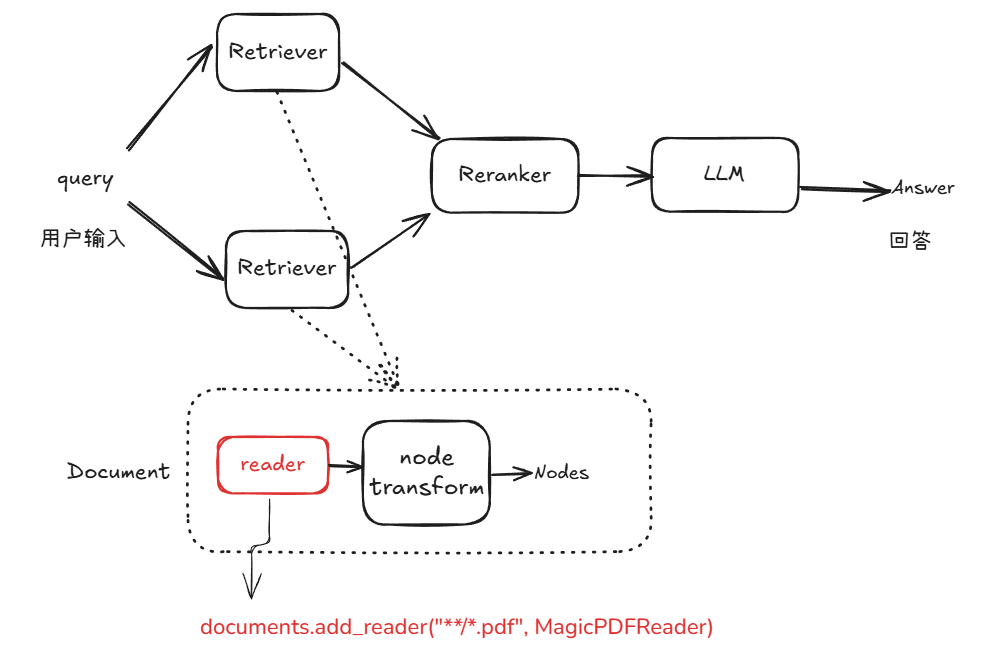

对于一个如下图所示的跨页并且混排了表格的文本，我们一起来看一下默认解析器和MinerU的解析效果的比对。

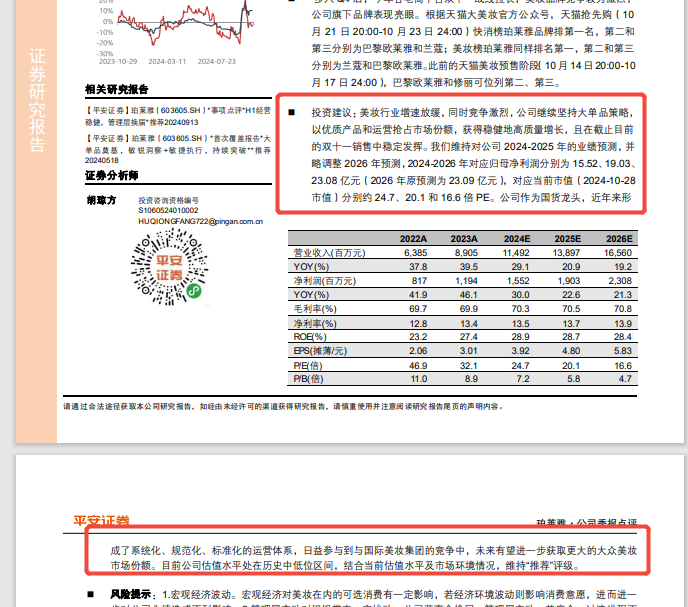

默认解析器解析效果：

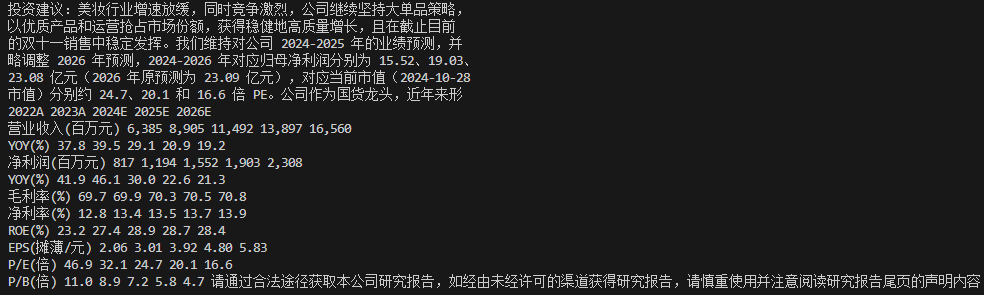

MinerU解析效果：

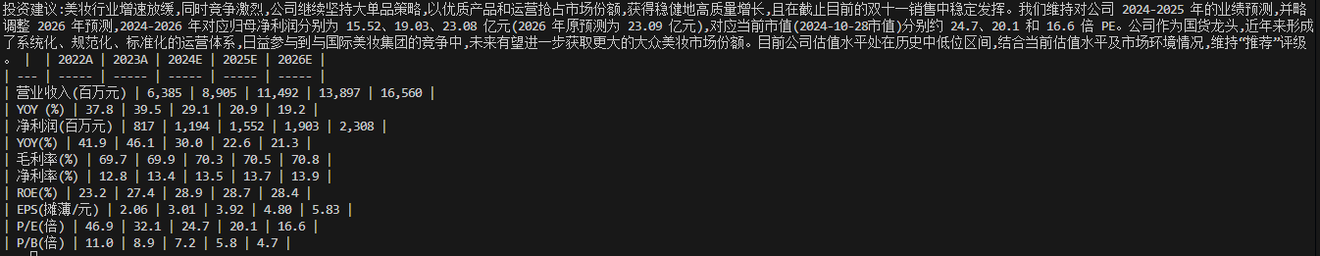

从结果上看，基于magic-pdf的解析器可以自动还原文档的跨页结构，将表格单独提出并且很好的还原了表格结构；但是默认解析器仅做到了文字提取，表格和文字混排且无法还原表格结构，具有干扰性的页脚信息也没有去除。

除了保留原文档的结构和格式、自动删除页眉、页脚、脚注、页码等元素，基于magic-pdf的解析器还可以提取图片等多模态内容，这里不做一一展示。

> 注意：由于 magic-pdf 使用到了模型进行 ocr 识别，所以整个过程会比较慢，如果想要加快速度，需要把模型部署到 GPU 上才行。

**至此，我们已经学习完关于自定义 Reader 的所有操作了。**